<a href="https://colab.research.google.com/github/operixon/mlsg-kaggle/blob/master/mouseprobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO

- dodać feature angle


# Instalacje

In [2]:
!pip install trianglesolver

# Importy

In [3]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression
import trianglesolver as trsolve


# Zmienne globalne

# Dane

Głównym źródłem danych jest projekt na github https://github.com/operixon/mouseml
Składa się on z plików z danymi csv zawierającymi 3 kolumny:
- czas w milisekundach od rozpoczęcia sesji
- pozycja x
- pozycja y

Właściwe dane znajdują się w katalogach
test1/local/clean - sesja lokalna nagrano ruchy właściciela
test1/remote/clean - sesja zdalna nagrano ruchy osoby podłączonej zdalnym pulpitem

Sesje lokalne i zdalne następowały po sobie tak aby zasymulować dokładny przebieg przejęcia.


## Pobranie danych z git

In [4]:
%%bash
rm -rf mouseml
git clone https://github.com/operixon/mouseml.git


Cloning into 'mouseml'...


In [5]:
!ls mouseml/test1/local/clean
!ls mouseml/test1/remote/clean

t1-artur-local-session-1.txt  t1-konrad-local-session-1-touhpad.txt
t1-artur-local-session-2.txt  t1-konrad-local-session-2-mouse.txt
t1-artur-remote-msteams-session1.txt  t1-konrad-remote-msteams-session1.txt
t1-artur-remote-msteams-session2.txt  t1-konrad-remote-msteams-session2.txt


## Czytanie danych 

- czytanie plików w katalogach (t x y)
- generowanie kolumn z cechami dx, dy, dt, liczba próbek w oknie, parametry statystyczne dla okna
- usuniecie wszystkich wierszy zawierających nule
- ustawienie indeksu jako kolumny zawierajacej timestamp
- sid : identyfikator sesji : a1, a2, k1, k2
- session : typ sesji remote , local
- file : nazwa pliku z danymi

---

- output : **mpd** ( dataframe zawierający oznaczone sesje )

### Mouse angle based feature

Poniższy obrazek pokazuje graficzną interpretację cech ang_x ang_y.


Źródło : 
https://www.researchgate.net/publication/221609904_An_Efficient_User_Verification_System_via_Mouse_Movements


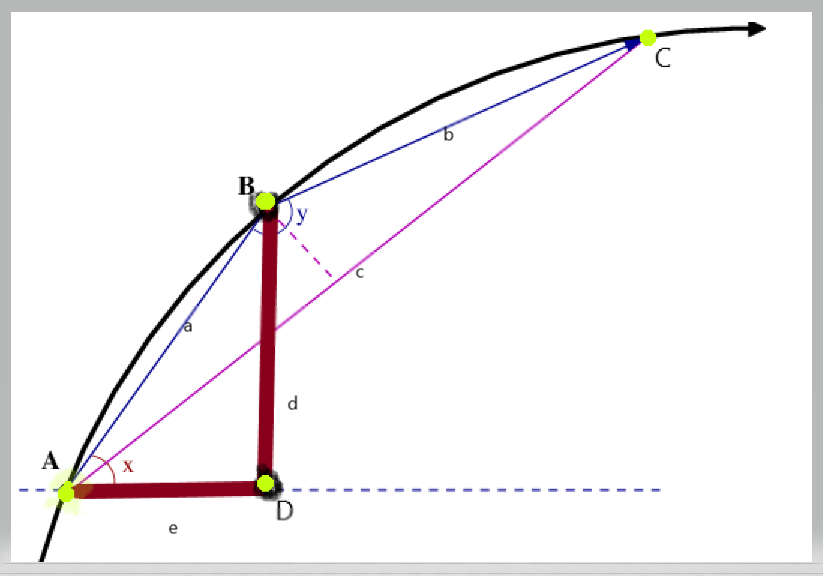

In [70]:
#TODO : przewijanie indexu do 0. Niektóre serie zaczynaja się np od 5 minuty
def preprocess(df):
  d = df#.copy()
 
  # Time indexes
  d['dt'] = d.t.diff()
  d['t_int'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  d['t'] = pd.to_timedelta(d['t'],unit='ms')
  d['t_ms'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  
  d.set_index(['t'],inplace=True)
  d = d.sort_index()

  # Dynamic features
  d['dx'],  d['dy'] = d.x.diff(),  d.y.diff()
  d['vx'],  d['vy'] = d.dx / d.dt, d.dy / d.dt
  d['dvx'], d['dvy'] = d.vx.diff(), d.vy.diff()
  d['ax'],  d['ay'] = d.dvx / d.dt,d.dvy / d.dt
  
  #add_angle_feature(d)  

  # Statistical features
  window_size='5s'
  d['count_1s'] = d.dx.rolling('1s').count()
  d['count_5s'] = d.dy.rolling('5s').count()
  d['count_10s'] = d.dy.rolling('10s').count()
  d['count_25s'] = d.dy.rolling('25s').count()
  d['count_60s'] = d.dy.rolling('60s').count()

  add_statistics_for_column("dx",d, window_size)
  add_statistics_for_column("dy",d, window_size)
  add_statistics_for_column("ax",d, window_size)
  add_statistics_for_column("ay",d, window_size)
  add_statistics_for_column("count_25s",d, window_size)

 # d = d.dropna()

  return d

def add_angle_feature(df):
  # dodaje kolumny z wartośxiami x, y z 2 poprzednich rekordów
  d_shift_1 = df.shift(periods=1, fill_value=0)
  d_shift_2 = df.shift(periods=2, fill_value=0)
  df['Ax'] = d_shift_1.x
  df['Ay'] = d_shift_1.y
  df['Bx'] = d_shift_2.x
  df['By'] = d_shift_2.y
  df['Cx'] = df.x
  df['Cy'] = df.y
  print(df.Ax)
  df['ang_x'] = df.apply(lambda x : x['Ax'])
  df['ang_x'] = df.apply(lambda x : get_angle_x(x['Ax'],
                                                x['Ay'],
                                                x['Bx'],
                                                x['By'])) 
  df['ang_y'] = df.apply(lambda x : get_angle_y(x['Ax'],
                                                 x['Ay'],
                                                 x['Bx'],
                                                 x['By'],
                                                 x['Cx'],
                                                 x['Cy'])) 

def get_angle_x(Ax,Ay,Bx,By):
  Dx,Dy = Bx,Ay
  a = get_distance(Ax,Ay,Bx,By)
  d = get_distance(Bx,By,Dx,Dy)
  e = get_distance(Ax,Ay,Dx,Dy)
  # triangle solver example usage
  # a,b,c,A,B,C = solve(b=7.6, c=8.3, A=pi/3)
  _, _, _, _, angle_x, _ = trsolve.solve(a=a,b=d,c=e)
  return angle_x


def get_angle_y(Ax,Ay,Bx,By,Cx,Cy):
  Dx,Dy = Bx,Ay
  a = get_distance(Ax,Ay,Bx,By)
  b = get_distance(Bx,By,Cx,Cy)
  c = get_distance(Cx,Cy,Ax,Ay)
  _, _, _, _, _, angle_y = trsolve.solve(a=a,b=b,c=c)
  return angle_y

# długość odcinka
def get_distance(x1, x2, y1, y2):
    diffX = abs(x2 - x1)
    diffY = abs(y2 - y1)
    return math.hypot(diffX, diffY) # a^2 + b^2


def add_statistics_for_column(columnName, d, window_size):

  d[f"std_{columnName}"]   = d[columnName].rolling(window_size).std()
  d[f"mean_{columnName}"]   = d[columnName].rolling(window_size).mean()
  d[f"median_{columnName}"] = d[columnName].rolling(window_size).median()
  d[f"cov_{columnName}"]    = d[columnName].rolling(window_size).cov()
  d[f"skew_{columnName}"]   = d[columnName].rolling(window_size).skew()
  d[f"kurt_{columnName}"]   = d[columnName].rolling(window_size).kurt()
  d[f"ql_{columnName}"]     = d[columnName].rolling(window_size).quantile(.2, interpolation='midpoint')
  d[f"qh_{columnName}"]     = d[columnName].rolling(window_size).quantile(.8, interpolation='midpoint')


def readFromFile(f):
  print(f)
  d = pd.read_csv(f, skiprows=3, header=None)
  d.columns =  ["t","x","y"]
  d['file'] = f
  return preprocess(d)

def readFromDir(dir,session) :
  localData = pd.concat(map(readFromFile, glob.glob(os.path.join(dir, "*.txt"))))
  localData['session'] = session
  return localData

def loadData() :
  d = pd.concat([readFromDir('mouseml/test1/local/clean/','local'),
                 readFromDir('mouseml/test1/remote/clean/','remote')])
  # Workaround
  d['sid'] = ""
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-2.txt','sid'] = "a2"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt','sid']= "k2" 
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-1.txt','sid']= "a1"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt','sid']= "k1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt','sid']= "a2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt','sid']="a1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt','sid']="k2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt','sid']="k1"
  d = d.replace([np.inf, -np.inf], np.nan)
  d = d.dropna()
  return d


mdp = loadData()



mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt
mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt
mouseml/test1/local/clean/t1-artur-local-session-1.txt
mouseml/test1/local/clean/t1-artur-local-session-2.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt


# Podstawowe statystyki

In [7]:
mdp

,x,y,file,dt,t_int,t_ms,dx,dy,vx,vy,dvx,dvy,ax,ay,count_1s,count_5s,count_10s,count_25s,count_60s,std_dx,mean_dx,median_dx,cov_dx,skew_dx,kurt_dx,ql_dx,qh_dx,std_dy,mean_dy,median_dy,cov_dy,skew_dy,kurt_dy,ql_dy,qh_dy,std_ax,mean_ax,median_ax,cov_ax,skew_ax,kurt_ax,ql_ax,qh_ax,std_ay,mean_ay,median_ay,cov_ay,skew_ay,kurt_ay,ql_ay,qh_ay,std_count_25s,mean_count_25s,median_count_25s,cov_count_25s,skew_count_25s,kurt_count_25s,ql_count_25s,qh_count_25s,session,sid
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 days 00:08:12.892000,1068,323,mouseml/test1/local/clean/t1-konrad-local-sess...,NaN,492892,0 days 00:08:12.892000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,local,k2
0 days 00:08:12.901000,1012,340,mouseml/test1/local/clean/t1-konrad-local-sess...,9.0,492901,0 days 00:08:12.901000,-56.0,17.0,-6.222222,1.888889,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,-56.000000,-56.0,NaN,NaN,NaN,-56.0,-56.0,NaN,17.000000,17.0,NaN,NaN,NaN,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.0,NaN,NaN,NaN,1.0,1.0,local,k2
0 days 00:08:12.911000,974,349,mouseml/test1/local/clean/t1-konrad-local-sess...,10.0,492911,0 days 00:08:12.911000,-38.0,9.0,-3.800000,0.900000,2.422222,-0.988889,0.242222,-0.098889,2.0,2.0,2.0,2.0,2.0,12.727922,-47.000000,-47.0,162.000000,NaN,NaN,-47.0,-47.0,5.656854,13.000000,13.0,32.000000,NaN,NaN,13.0,13.0,NaN,0.242222,0.242222,NaN,NaN,NaN,0.242222,0.242222,NaN,-0.098889,-0.098889,NaN,NaN,NaN,-0.098889,-0.098889,0.707107,1.500000,1.5,0.500000,NaN,NaN,1.5,1.5,local,k2
0 days 00:08:12.916000,940,354,mouseml/test1/local/clean/t1-konrad-local-sess...,5.0,492916,0 days 00:08:12.916000,-34.0,5.0,-6.800000,1.000000,-3.000000,0.100000,-0.600000,0.020000,3.0,3.0,3.0,3.0,3.0,11.718931,-42.666667,-38.0,137.333333,-1.507808,NaN,-47.0,-36.0,6.110101,10.333333,9.0,37.333333,0.935220,NaN,7.0,13.0,0.595541,-0.178889,-0.178889,0.354669,NaN,NaN,-0.178889,-0.178889,0.084067,-0.039444,-0.039444,0.007067,NaN,NaN,-0.039444,-0.039444,1.000000,2.000000,2.0,1.000000,-7.993606e-15,NaN,1.5,2.5,local,k2
0 days 00:08:12.926000,906,362,mouseml/test1/local/clean/t1-konrad-local-sess...,10.0,492926,0 days 00:08:12.926000,-34.0,8.0,-3.400000,0.800000,3.400000,-0.200000,0.340000,-0.020000,4.0,4.0,4.0,4.0,4.0,10.503968,-40.500000,-36.0,110.333333,-1.817181,3.293179,-47.0,-34.0,5.123475,9.750000,8.5,26.250000,1.329083,2.374603,6.5,13.0,0.516801,-0.005926,0.242222,0.267083,-1.662561,NaN,-0.178889,0.291111,0.060495,-0.032963,-0.020000,0.003660,-0.919988,NaN,-0.059444,0.000000,1.290994,2.500000,2.5,1.666667,0.000000e+00,-1.200000,1.5,3.5,local,k2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:06:44.217000,938,509,mouseml/test1/remote/clean/t1-artur-remote-mst...,214.0,404217,0 days 00:06:44.217000,-3.0,-2.0,-0.014019,-0.009346,0.157410,0.104940,0.000736,0.000490,7.0,28.0,43.0,123.0,316.0,27.606360,3.500000,-0.5,762.111111,2.793890,12.134053,-6.5,7.0,33.982002,6.035714,0.0,1154.776455,0.649777,1.474083,-10.5,20.0,0.013151,-0.003543,-0.000147,0.000173,-3.463609,15.396835,-0.003959,0.000966,0.039466,0.004997,-0.000076,0.001558,3.689627,17.427277,-0.005861,0.008962,2.454614,116.892857,117.0,6.025132,7.964706e-01,0.492531,115.0,118.0,remote,a1
0 days 00:06:44.251000,938,504,mouseml/test1/remote/clean/t1-artur-remote-mst...,34.0,404251,0 days 00:06:44.251000,0.0,-5.0,0.000000,-0.147059,0.014019,-0.137713,0.000412,-0.004050,8.0,27.0,44.0,124.0,317.0,27.756316,4.518519,0.0,770.413105,2.762686,12.006864,-5.5,7.0,33.662731,3.888889,-2.0,1133.179487,0.826505,1.992594,-10.5,17.0,0.006452,-0.001146,0.000000,0.000042,-0.545449,4.098323,-0.003346,0

In [8]:
mdp.info() 


<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 39609 entries, 0 days 00:08:12.892000 to 0 days 00:06:44.968000
Data columns (total 61 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   x                 39609 non-null  int64          
 1   y                 39609 non-null  int64          
 2   file              39609 non-null  object         
 3   dt                39601 non-null  float64        
 4   t_int             39609 non-null  int64          
 5   t_ms              39609 non-null  timedelta64[ns]
 6   dx                39601 non-null  float64        
 7   dy                39601 non-null  float64        
 8   vx                39591 non-null  float64        
 9   vy                39586 non-null  float64        
 10  dvx               39573 non-null  float64        
 11  dvy               39563 non-null  float64        
 12  ax                39573 non-null  float64        
 13  ay                3

In [9]:
mdp.describe()

,x,y,dt,t_int,t_ms,dx,dy,vx,vy,dvx,dvy,ax,ay,count_1s,count_5s,count_10s,count_25s,count_60s,std_dx,mean_dx,median_dx,cov_dx,skew_dx,kurt_dx,ql_dx,qh_dx,std_dy,mean_dy,median_dy,cov_dy,skew_dy,kurt_dy,ql_dy,qh_dy,std_ax,mean_ax,median_ax,cov_ax,skew_ax,kurt_ax,ql_ax,qh_ax,std_ay,mean_ay,median_ay,cov_ay,skew_ay,kurt_ay,ql_ay,qh_ay,std_count_25s,mean_count_25s,median_count_25s,cov_count_25s,skew_count_25s,kurt_count_25s,ql_count_25s,qh_count_25s
count,39609.000000,39609.000000,39601.000000,3.960900e+04,39609,39601.000000,39601.000000,3.959100e+04,39586.0,3.957300e+04,3.956300e+04,3.957300e+04,3.956300e+04,39601.000000,39601.000000,39601.000000,39601.000000,39601.000000,39588.000000,39601.000000,39601.000000,39588.000000,39573.000000,39557.000000,39601.000000,39601.000000,39588.000000,39601.000000,39601.000000,39588.000000,39568.000000,39553.000000,39601.000000,39601.000000,3.957900e+04,39592.000000,39592.000000,3.958400e+04,3.956400e+04,3.954800e+04,39592.000000,39592.000000,39579.000000,39592.000000,39592.000000,3.958400e+04,39564.000000,3.954800e+04,39592.000000,39592.000000,39588.000000,39601.000000,39601.000000,39588.000000,39561.000000,39546.000000,39601.000000,39601.000000
mean,681.954657,385.140726,66.537259,4.404527e+05,0 days 00:07:20.452692948,0.047145,0.005000,NaN,NaN,NaN,NaN,NaN,NaN,29.520366,128.579682,245.189743,577.327037,1279.337037,16.752011,-0.153936,-0.083495,765.326478,-0.038129,6.894314,-6.085629,5.873968,9.725611,0.014859,0.040933,224.856731,-0.075663,5.513251,-3.726307,3.870205,4.677095e-01,0.001699,-0.000008,NaN,1.077304e+02,2.776356e+08,-0.015763,0.014943,0.260320,0.008530,0.000013,NaN,-1.999577,9.202786e+07,-0.010978,0.011025,21.440400,563.780025,564.055415,914.862662,-0.023324,-0.634340,542.885748,584.458486
std,219.023675,144.657552,226.050748,3.246273e+05,0 days 00:05:24.627272836,27.336046,15.133599,NaN,NaN,NaN,NaN,NaN,NaN,25.455517,98.871020,180.035901,418.845166,958.756418,22.016104,6.065829,3.086340,2571.841134,2.061500,7.024881,9.898685,8.853146,11.413699,2.741132,1.617207,732.895278,1.729453,6.244582,4.566744,4.390209,1.369516e+00,0.227706,0.004029,NaN,2.075266e+04,5.495385e+10,0.040933,0.020299,0.720480,0.126820,0.001162,NaN,206.266996,1.070769e+10,0.010527,0.011208,21.335028,416.242818,416.724213,1990.698911,0.598942,1.355092,405.995689,427.124163
min,0.000000,1.000000,0.000000,9.010000e+02,0 days 00:00:00.901000,-742.000000,-389.000000,-inf,-inf,-inf,-inf,-inf,-inf,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-138.666667,-123.500000,0.000000,-7.082503,-3.333333,-294.000000,-56.000000,0.000000,-39.000000,-39.000000,0.000000,-6.925261,-5.230500,-55.000000,-39.000000,3.295012e-07,-2.450109,-0.256939,-inf,-2.267774e+05,-1.226421e+06,-3.638883,-0.222215,0.000002,-2.375757,-0.098889,-inf,-25153.250185,-1.224525e+00,-0.098889,-0.098889,0.000063,1.000000,1.000000,0.000000,-5.819946,-6.000000,1.000000,1.000000
25%,523.000000,283.000000,10.000000,1.433100e+05,0 days 00:02:23.310000,-2.000000,-2.000000,-1.271284e-01,-0.1,-1.060606e-01,-9.648248e-02,-5.902226e-03,-4.325260e-03,12.000000,55.000000,104.000000,261.000000,551.000000,4.627133,-1.891304,-1.000000,21.410359,-1.495904,2.227075,-6.500000,1.000000,2.916478,-1.053333,0.000000,8.505841,-1.184402,1.531703,-4.500000,1.000000,2.529622e-02,-0.003490,0.000000,6.399214e-04,-3.205602e+00,1.291398e+01,-0.024781,0.003251,0.018389,-0.002327,0.000000,3.381021e-04,-3.211765,1.116963e+01,-0.016667,0.002711,7.481975,247.609756,247.500000,55.979957,-0.316412,-1.200000,239.500000,262.000000
50%,652.000000,390.000000,16.000000,3.436080e+05,0 days 00:05:43.608000,0.000000,0.000000,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.000000,91.000000,173.000000,389.000000,854.000000,7.905479,0.036398,0.000000,62.496594,0.064894,4.812478,-3.000000,3.000000,5.569794,-0.011730,0.000000,31.022605,0.037735,3.508793,-2.000000,3.000000,9.034664e-02,-0.000034,0.000000,8.166101e-03,1.346463e-01,2.853980e+01,-0.010000,0.010000,0.055430,0.000077,0.0

In [71]:
mdp.groupby('session').describe()

x                                 ... qh_count_25s                       
           count        mean         std    min  ...          25%    50%     75%     max
session                                          ...                                    
local    25421.0  675.022186  210.610792    0.0  ...        403.5  635.5  1108.0  1765.5
remote   13910.0  692.641481  230.971674  179.0  ...        193.0  288.5   328.0   436.0

[2 rows x 464 columns]

In [72]:
mdp.groupby(['file']).describe()

x  ... qh_count_25s
                                                      count  ...          max
file                                                         ...             
mouseml/test1/local/clean/t1-artur-local-sessio...   3120.0  ...        688.0
mouseml/test1/local/clean/t1-artur-local-sessio...   3543.0  ...        608.5
mouseml/test1/local/clean/t1-konrad-local-sessi...   4926.0  ...        625.0
mouseml/test1/local/clean/t1-konrad-local-sessi...  13832.0  ...       1765.5
mouseml/test1/remote/clean/t1-artur-remote-mste...   2789.0  ...        335.5
mouseml/test1/remote/clean/t1-artur-remote-mste...   2031.0  ...        324.0
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4605.0  ...        436.0
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4485.0  ...        393.5

[8 rows x 464 columns]

# EDA

## klastry

### Przyspieszenie

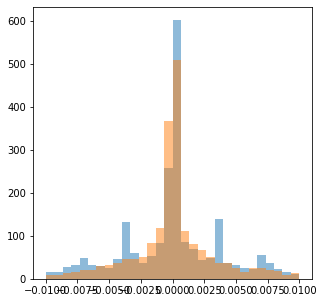

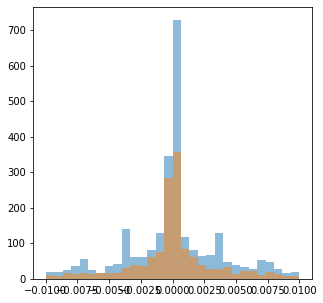

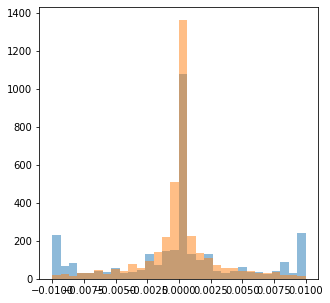

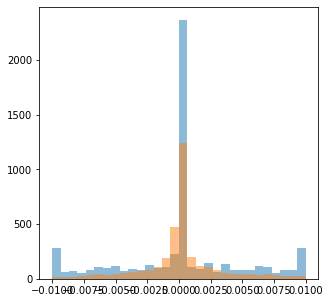

In [77]:

for sid_name, sid in mdp.groupby('sid'):
  fig, ax = plt.subplots(figsize=(5,5))
  
  for session_name, session in sid.groupby('session'):
    ax.hist(session.ax, bins=30, alpha=0.5,range=(-0.01,0.01))
  plt.show()




## Porównanie histogramów wartości cech dla sesji local i remote na całej sesji , ok 5 min

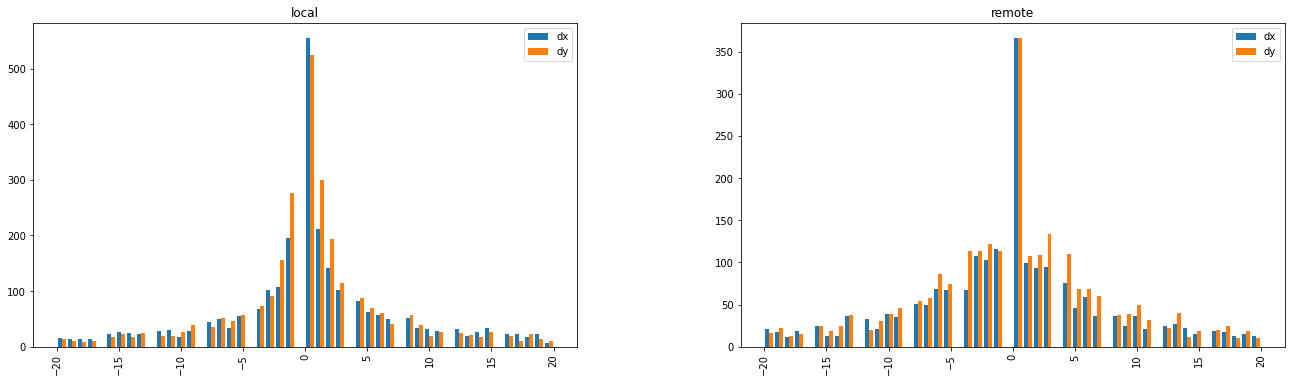

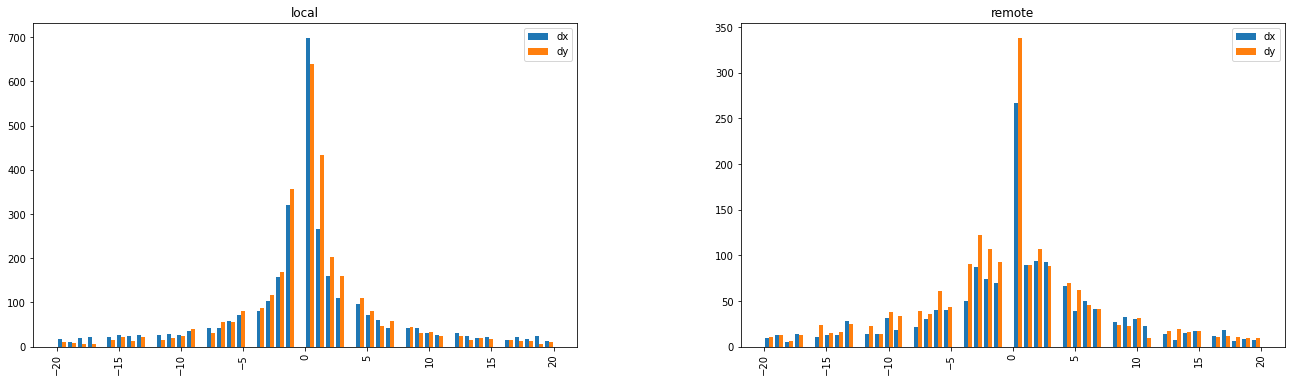

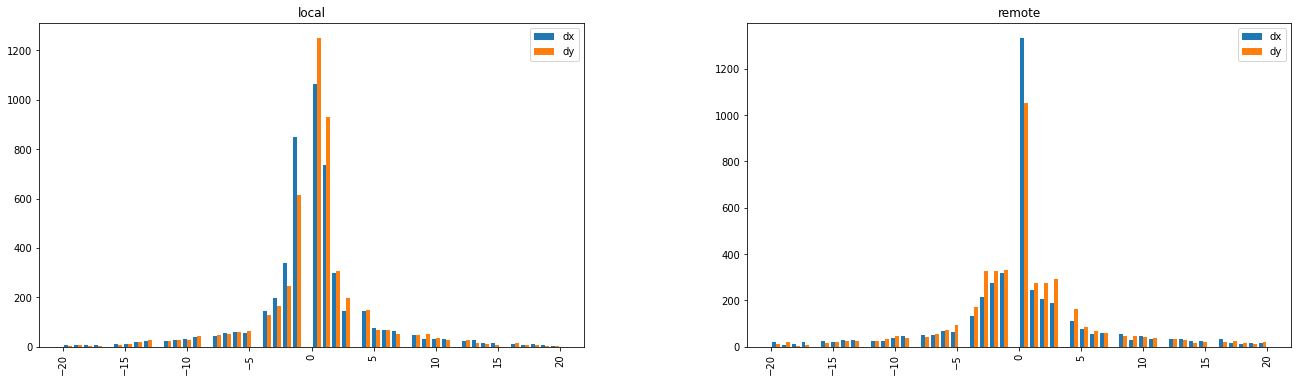

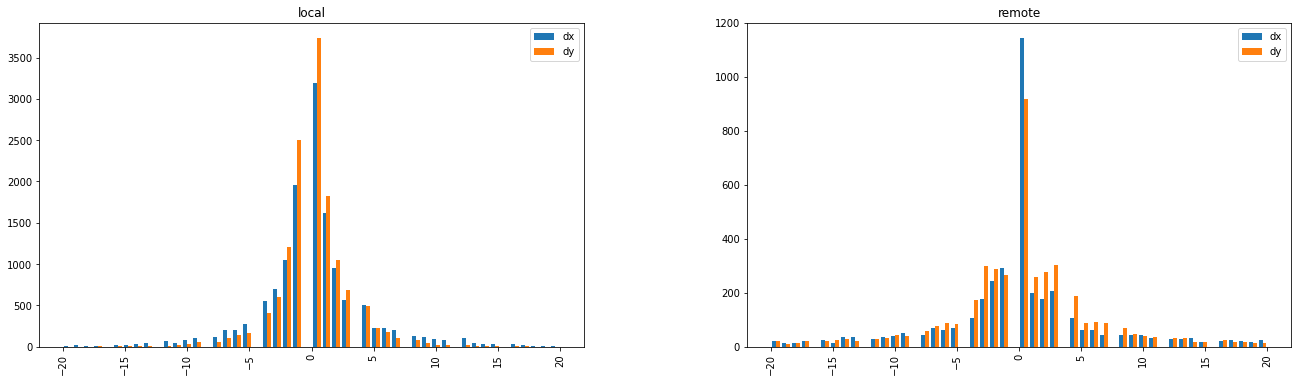

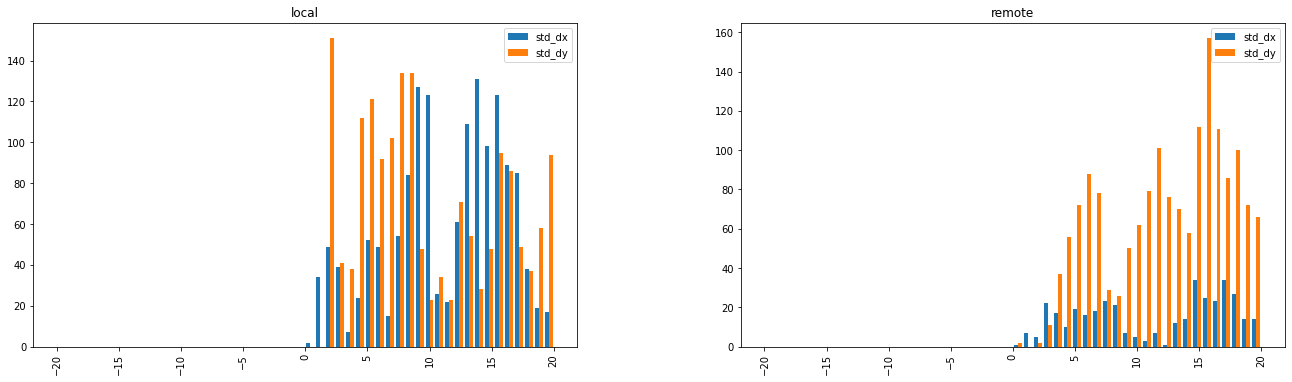

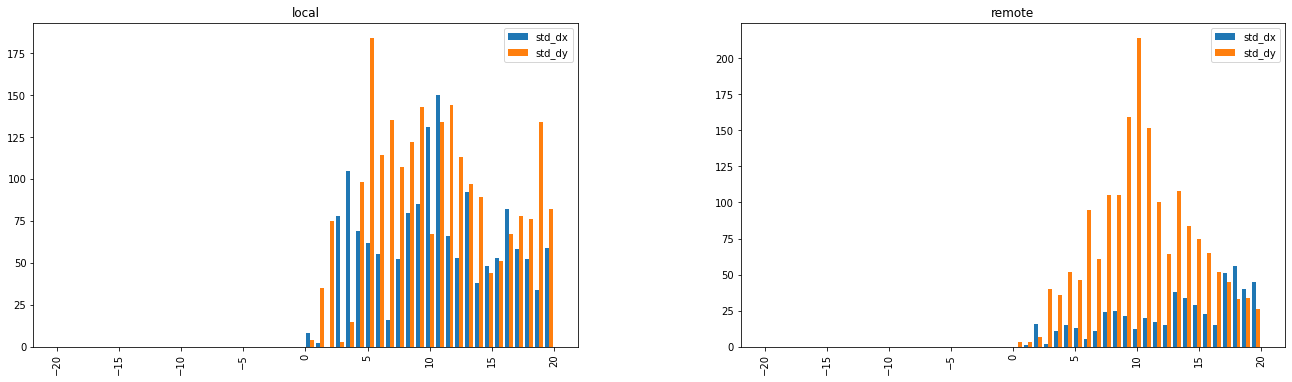

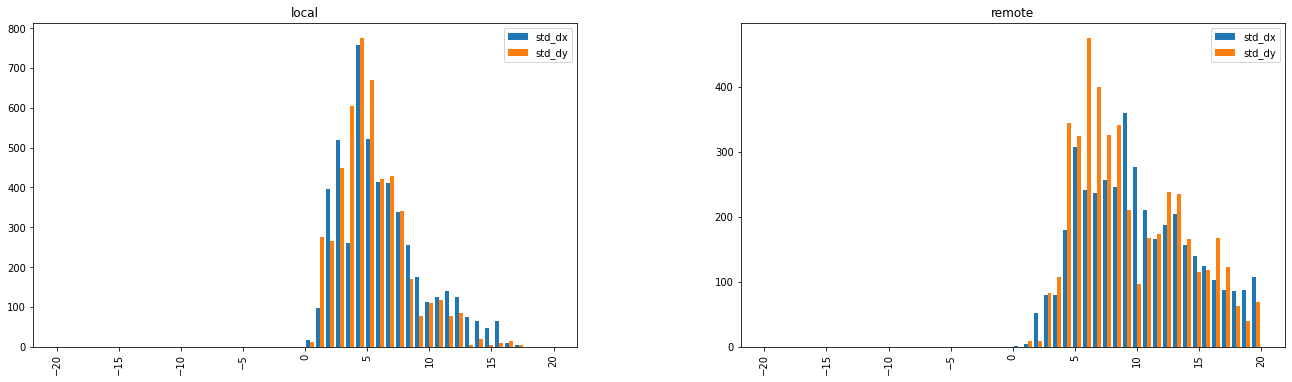

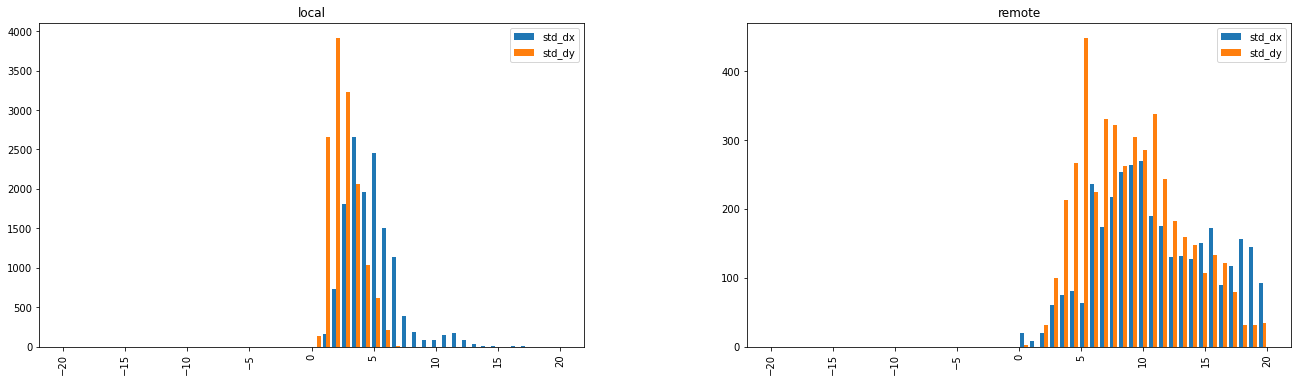

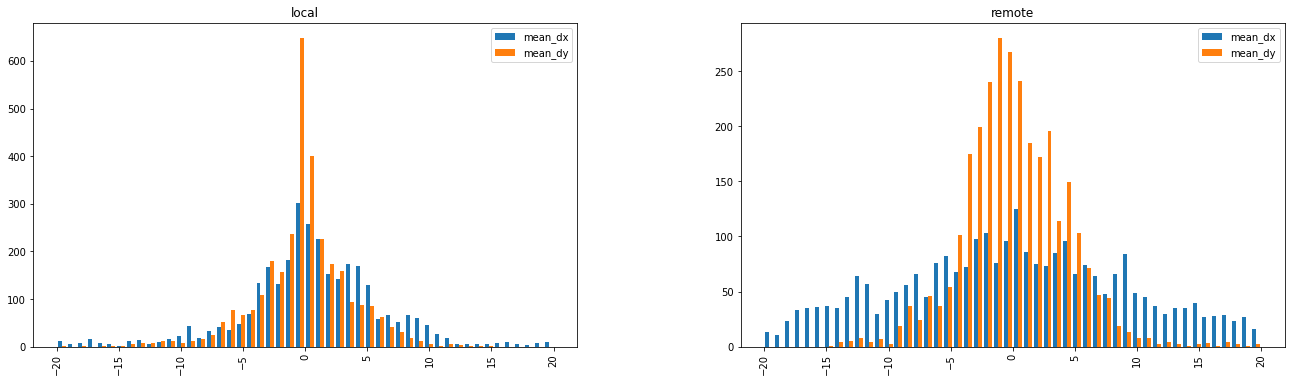

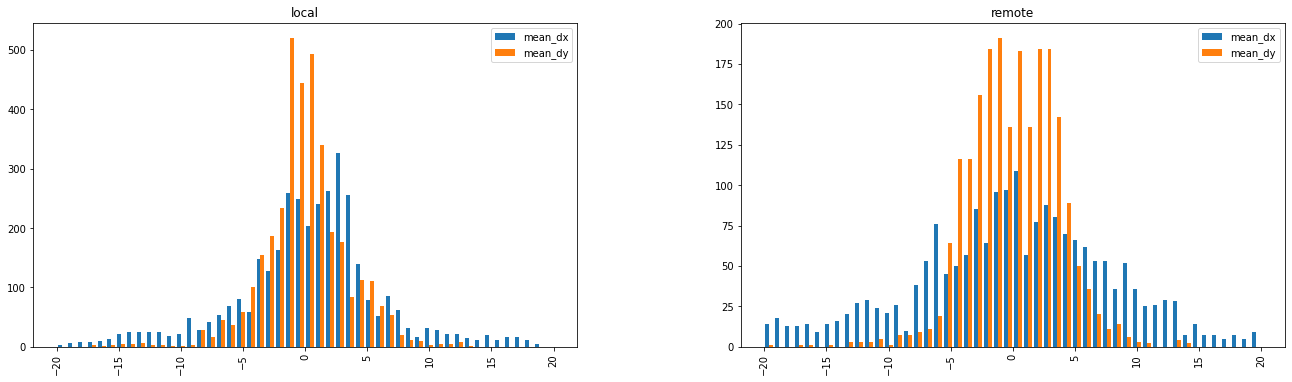

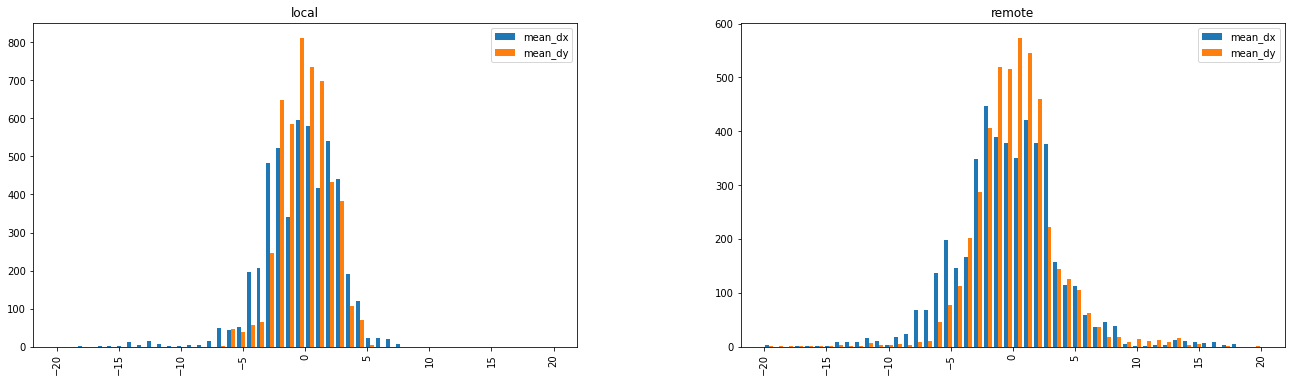

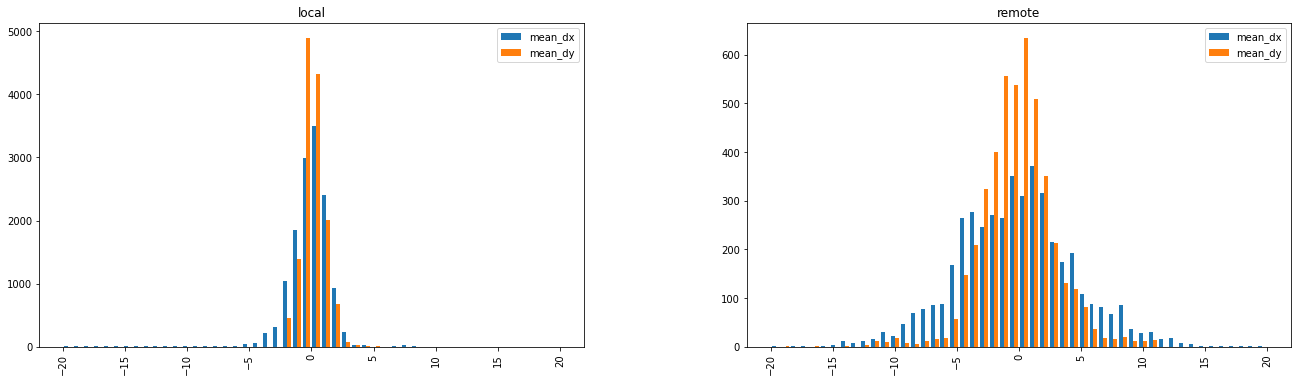

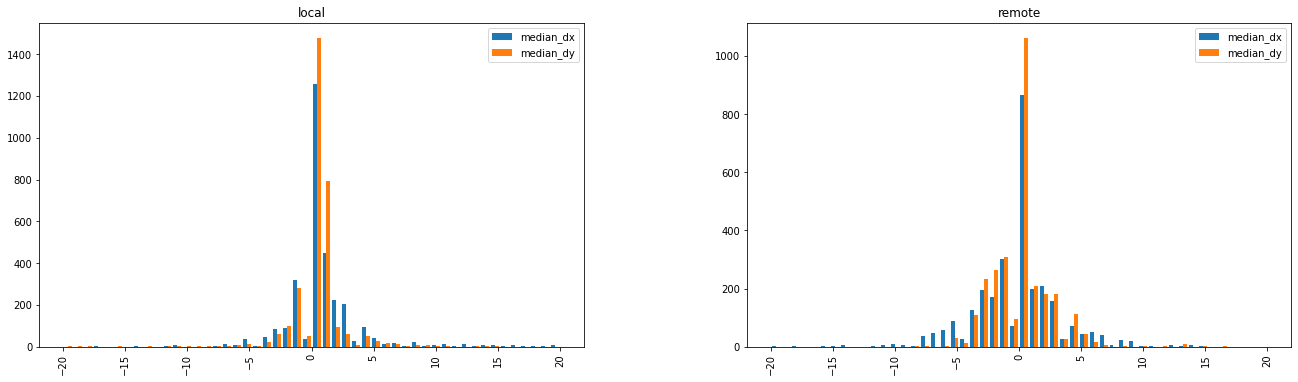

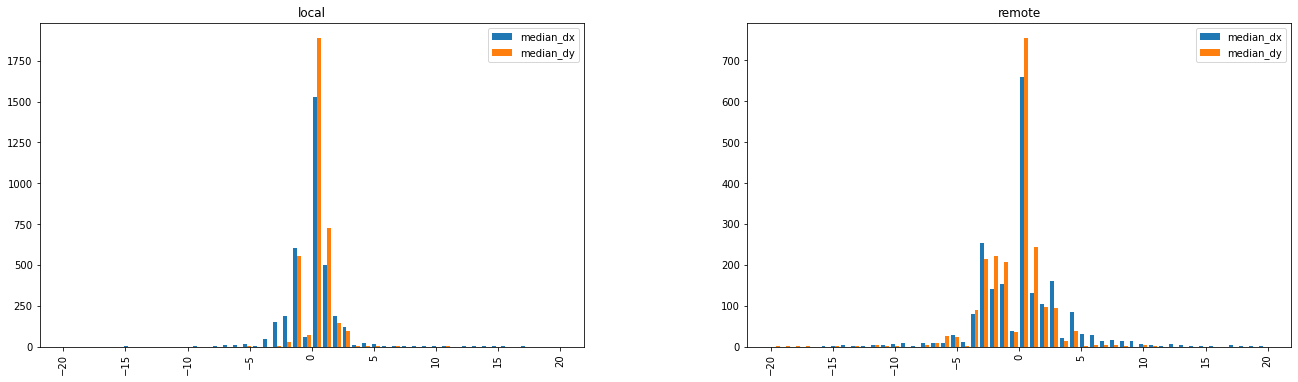

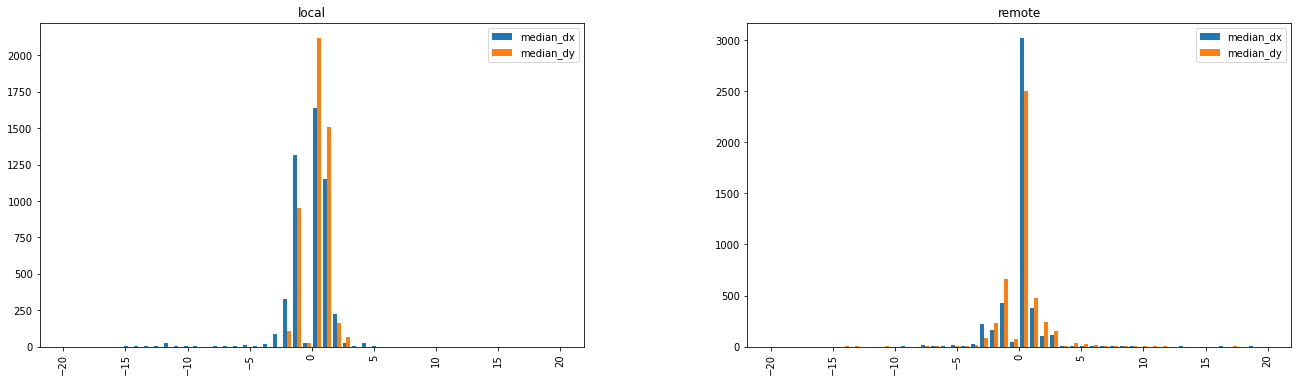

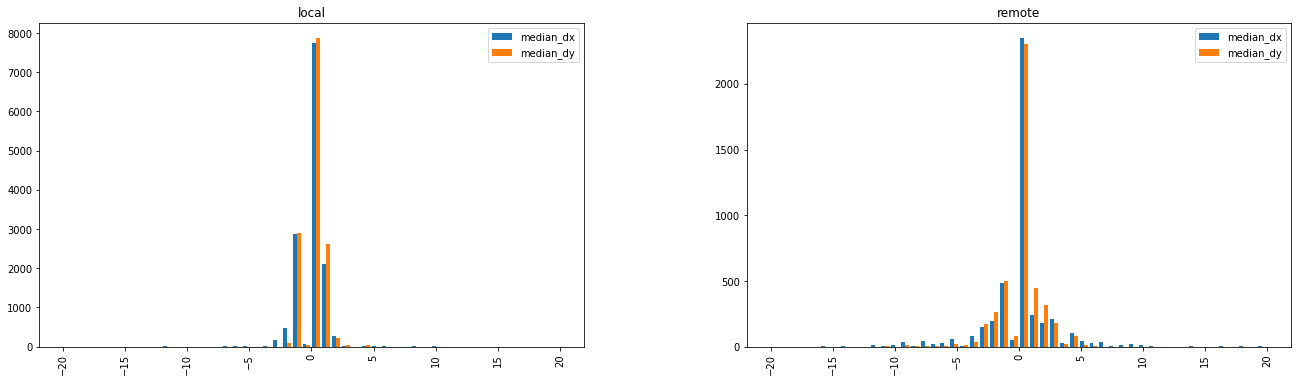

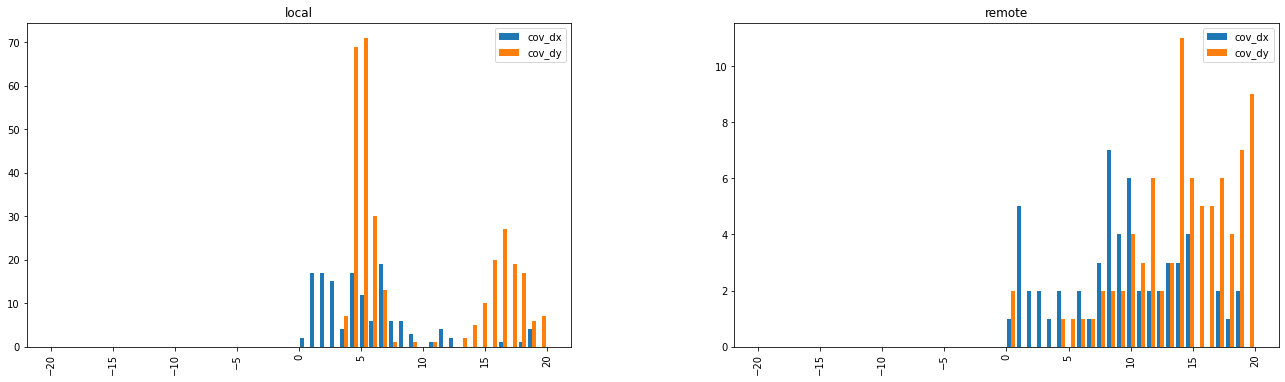

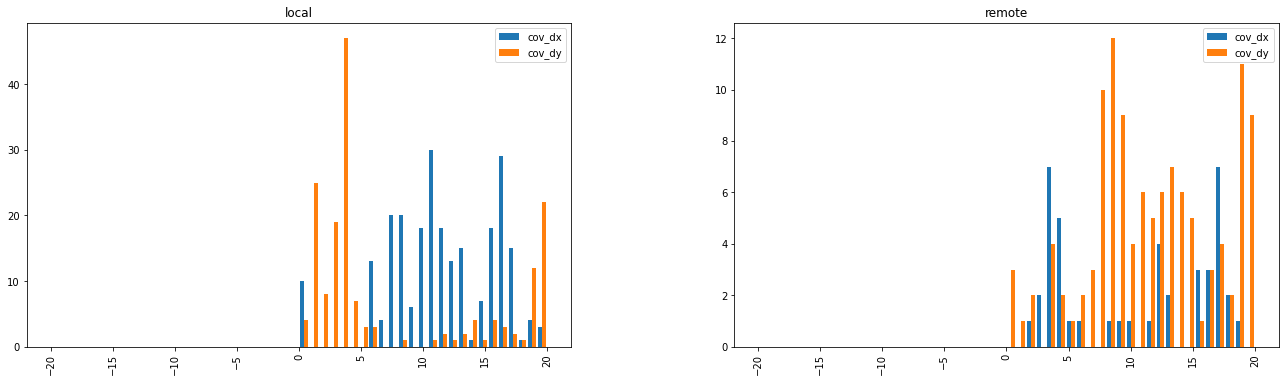

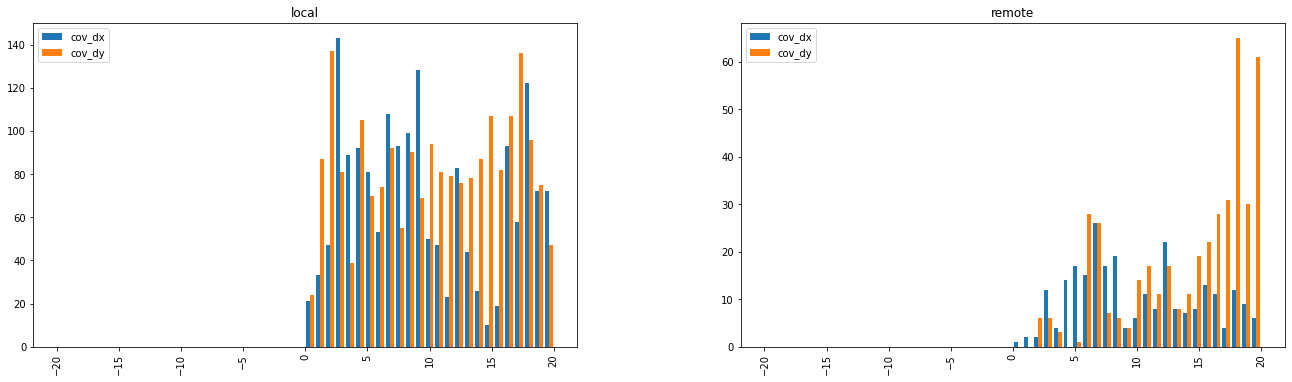

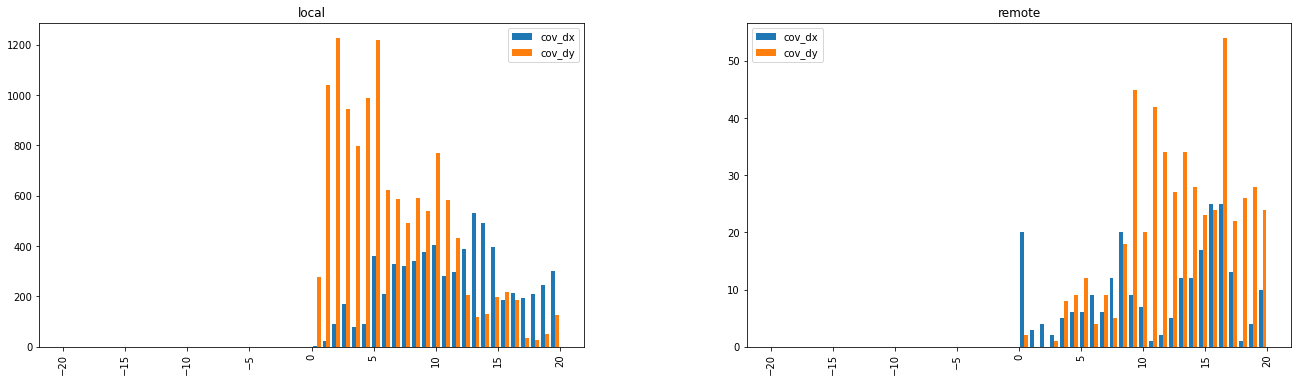

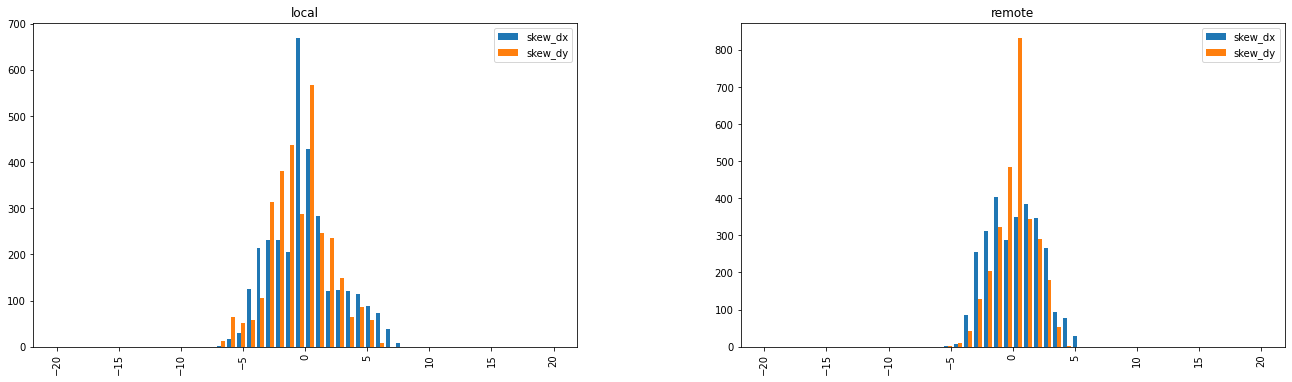

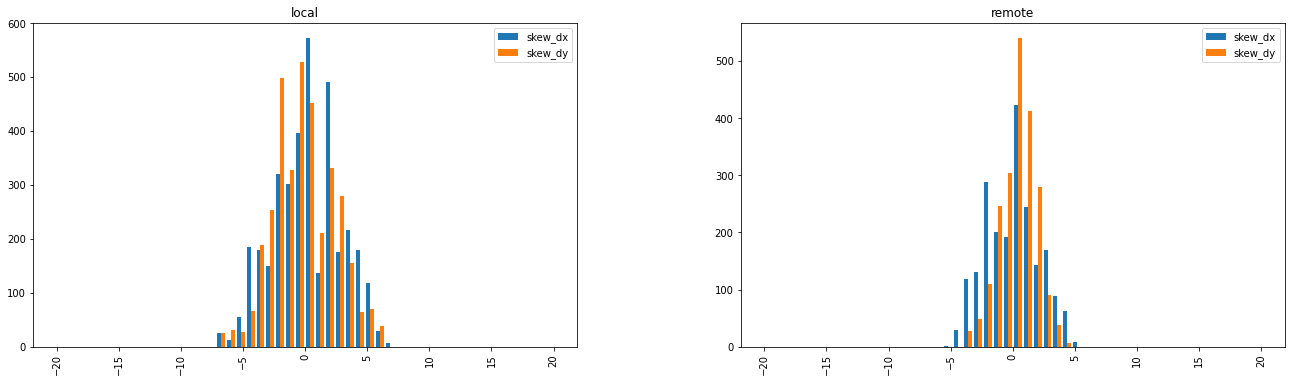

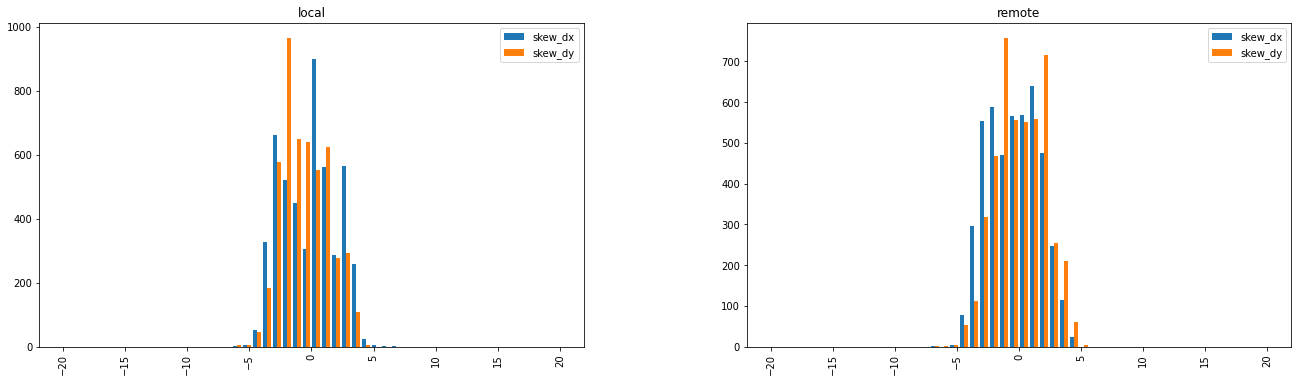

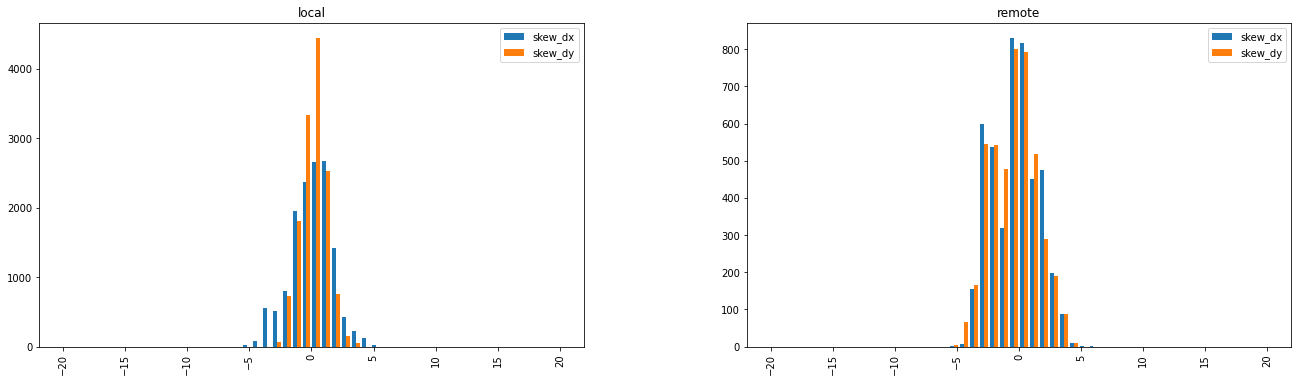

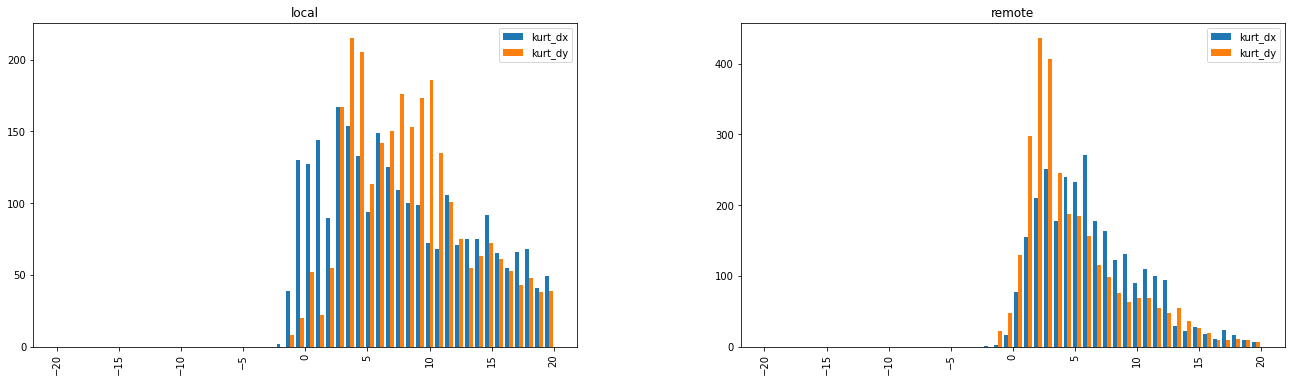

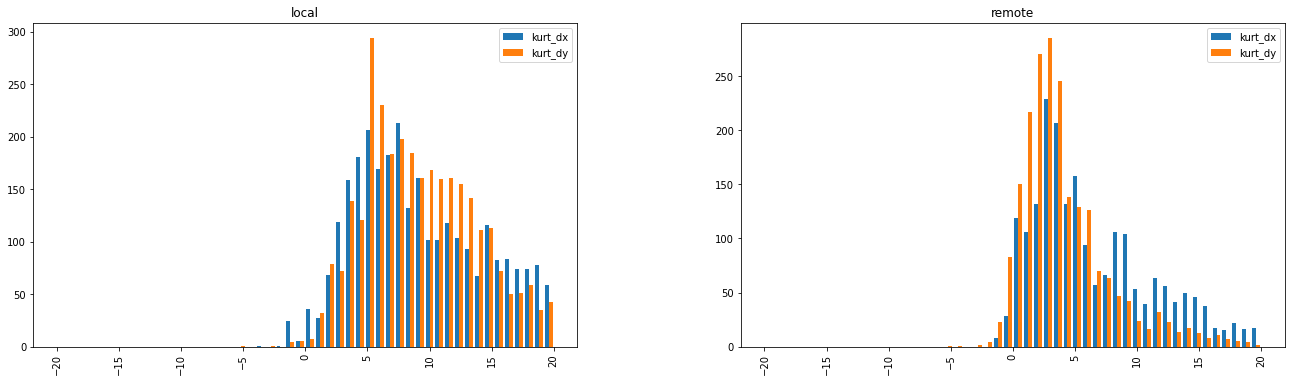

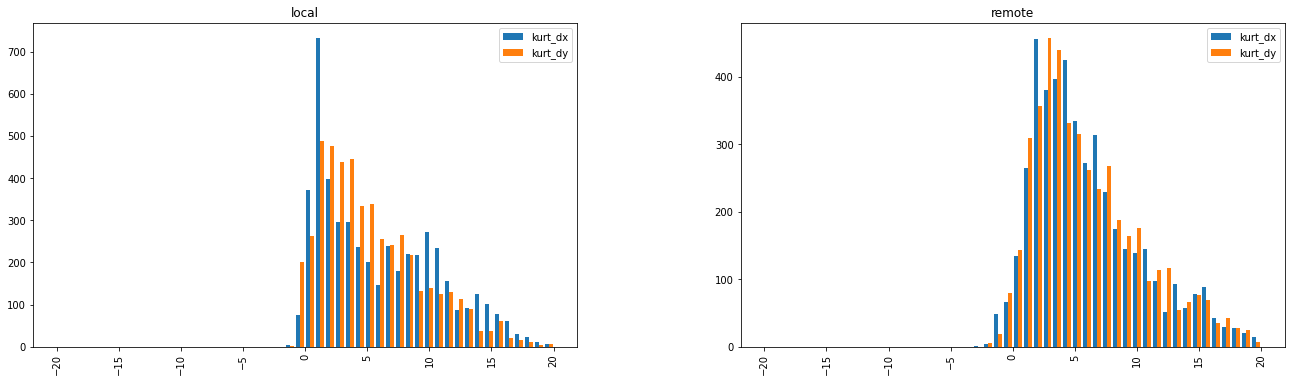

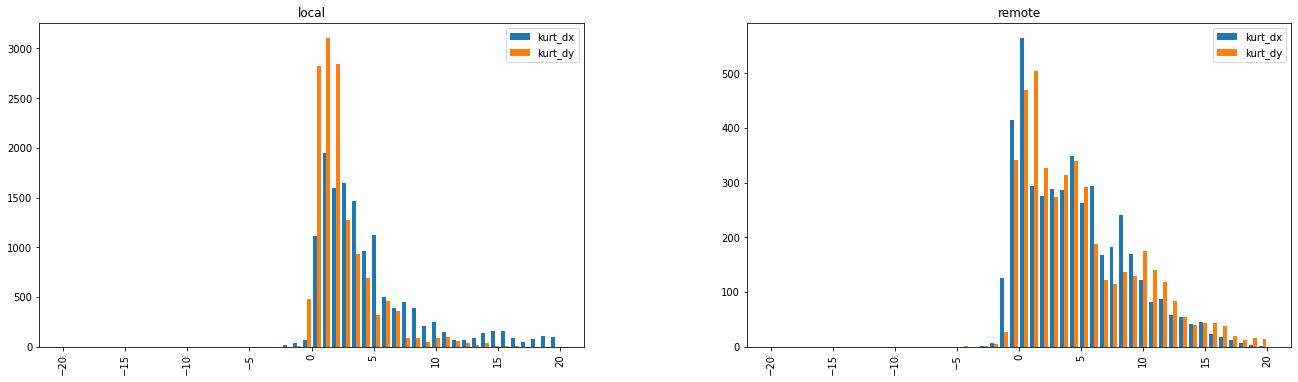

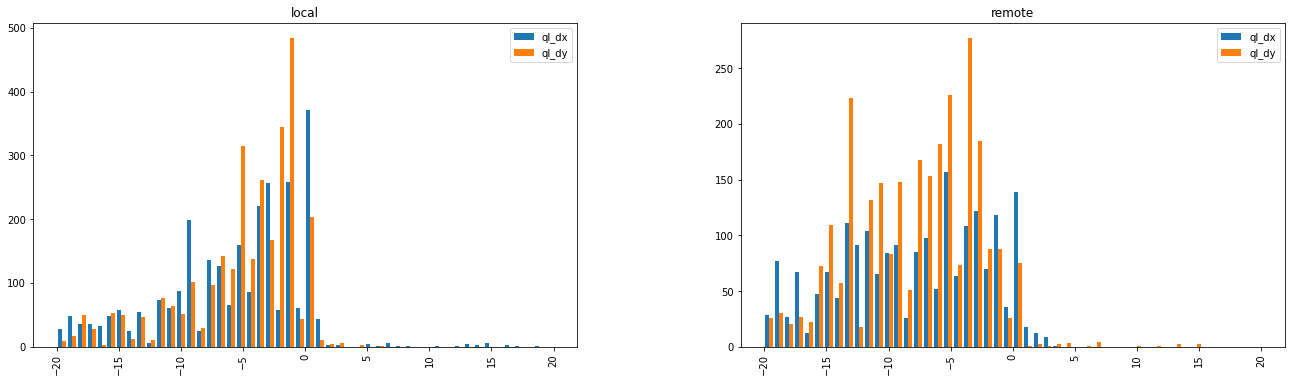

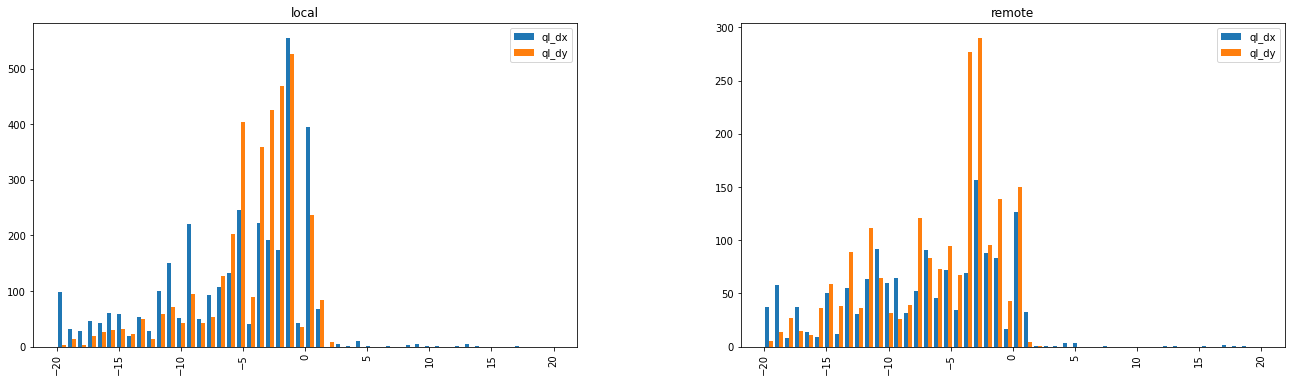

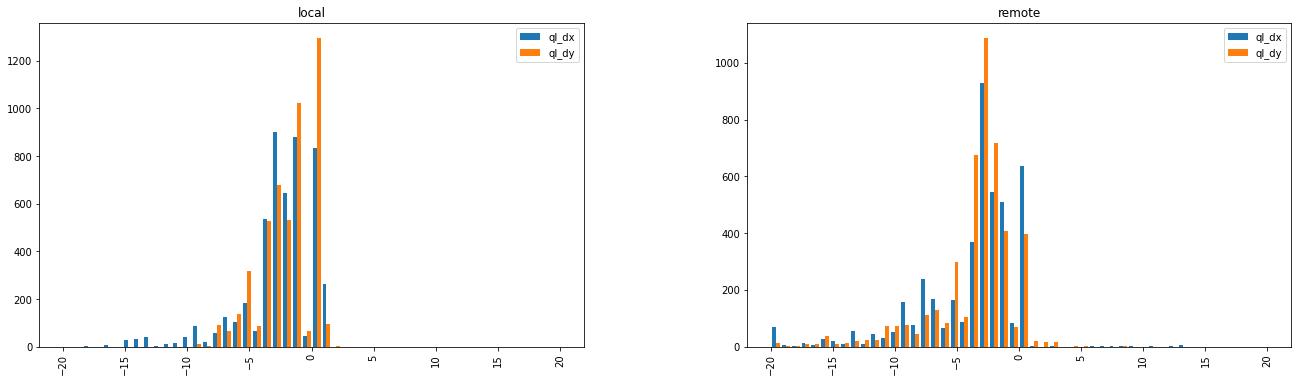

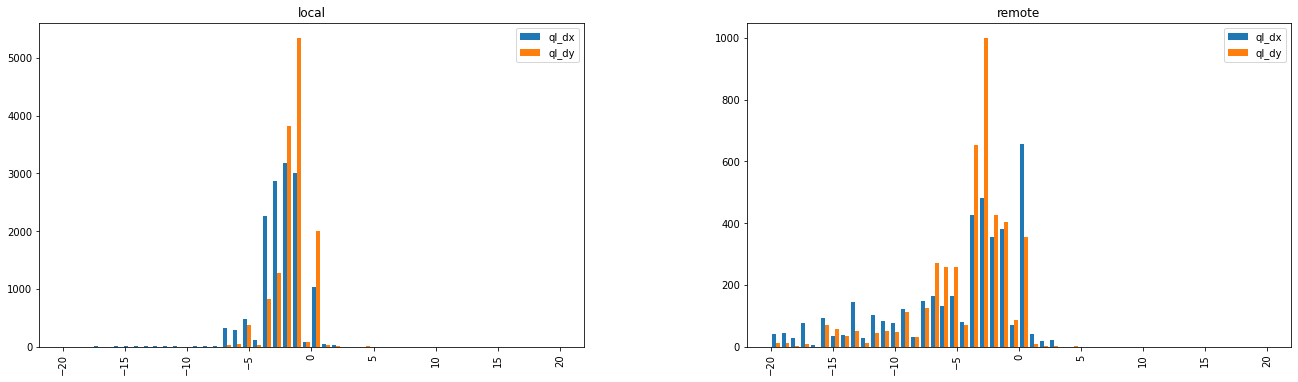

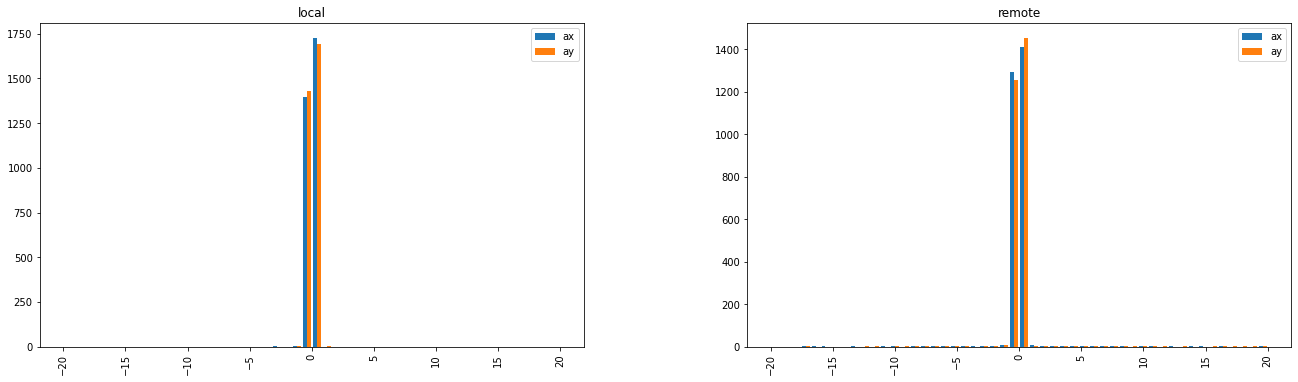

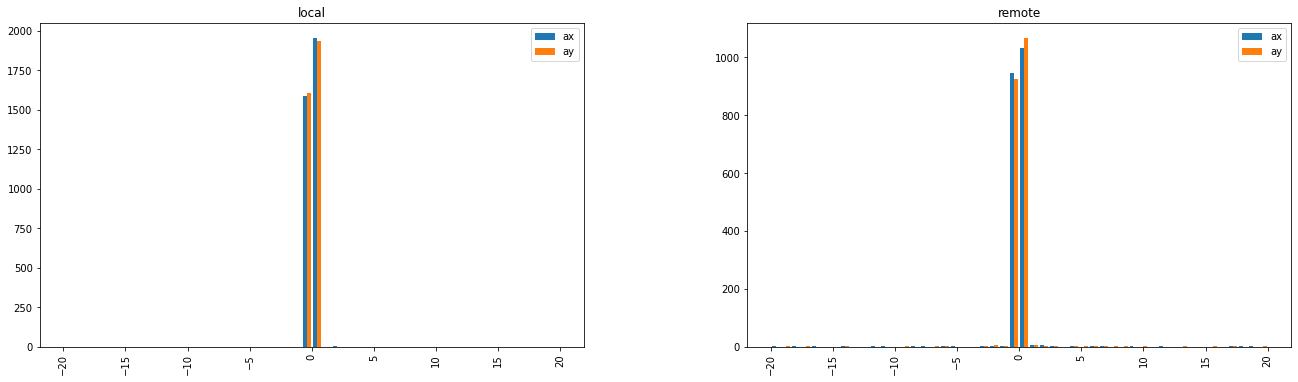

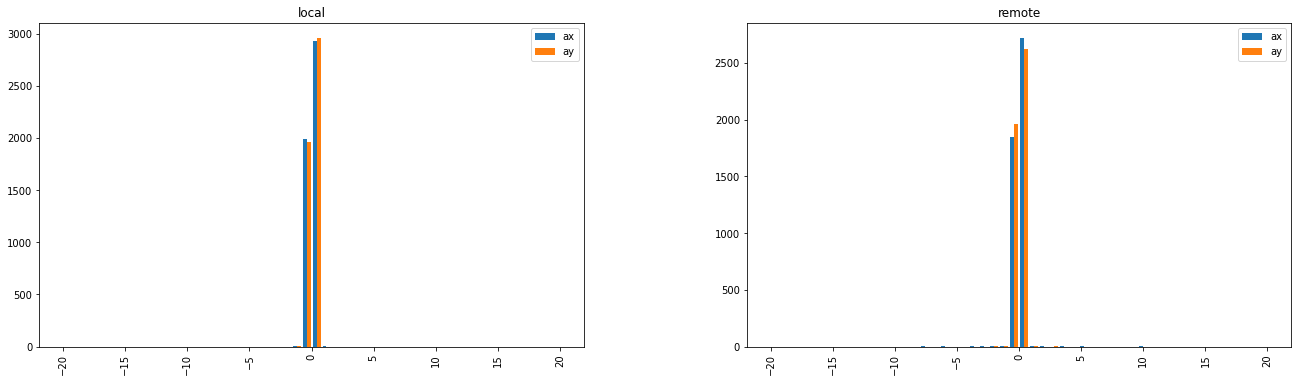

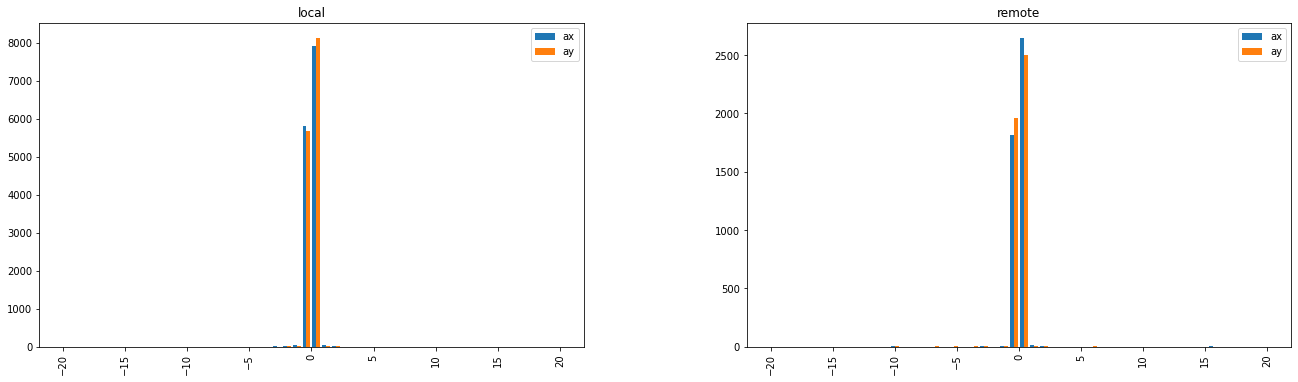

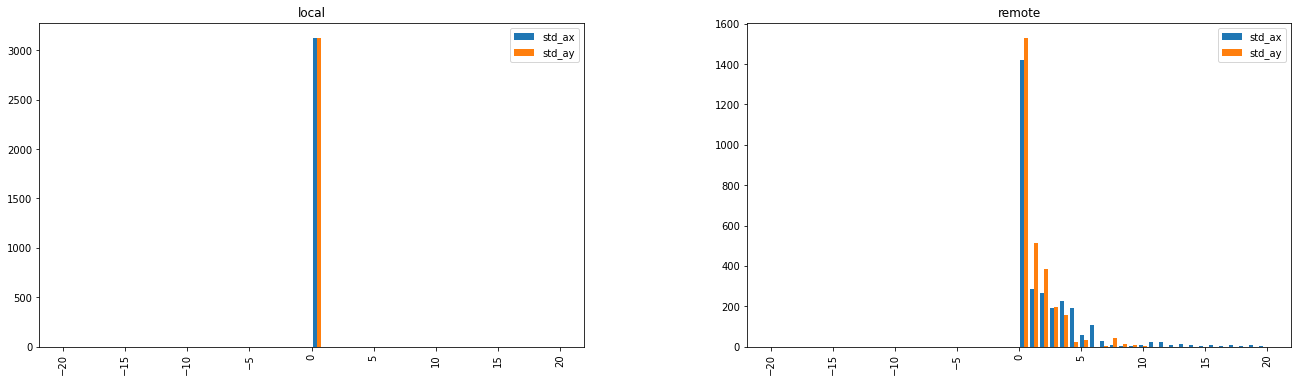

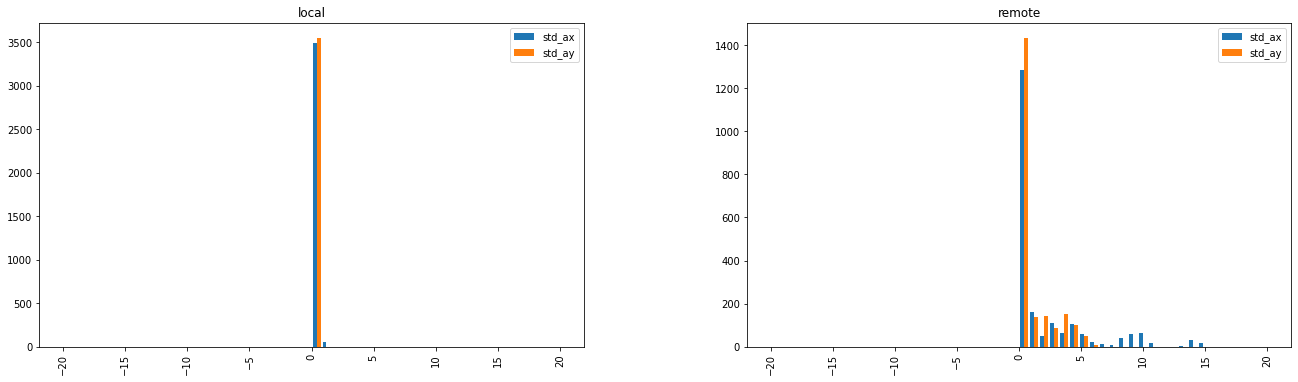

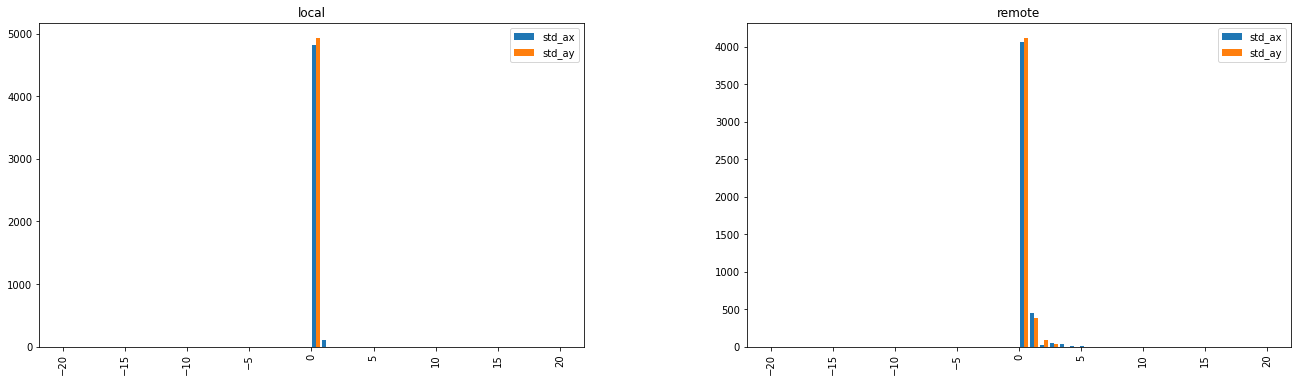

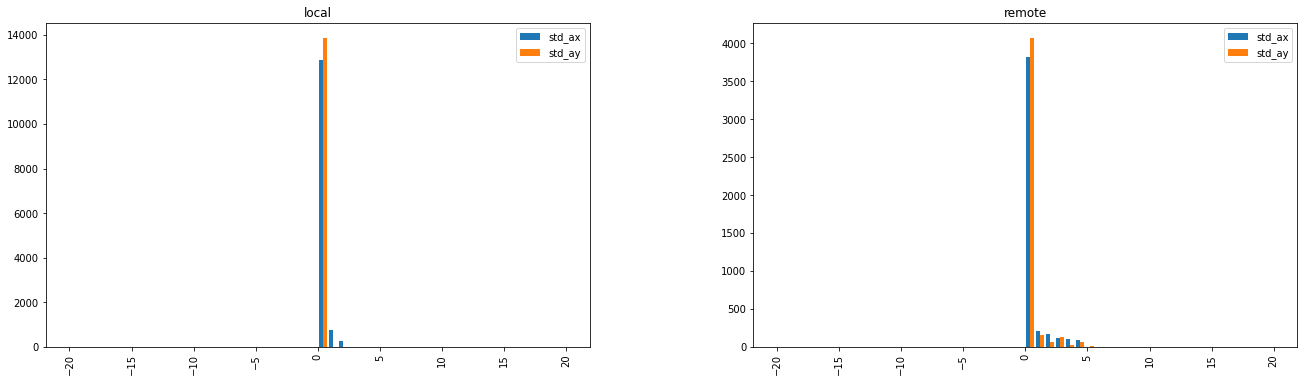

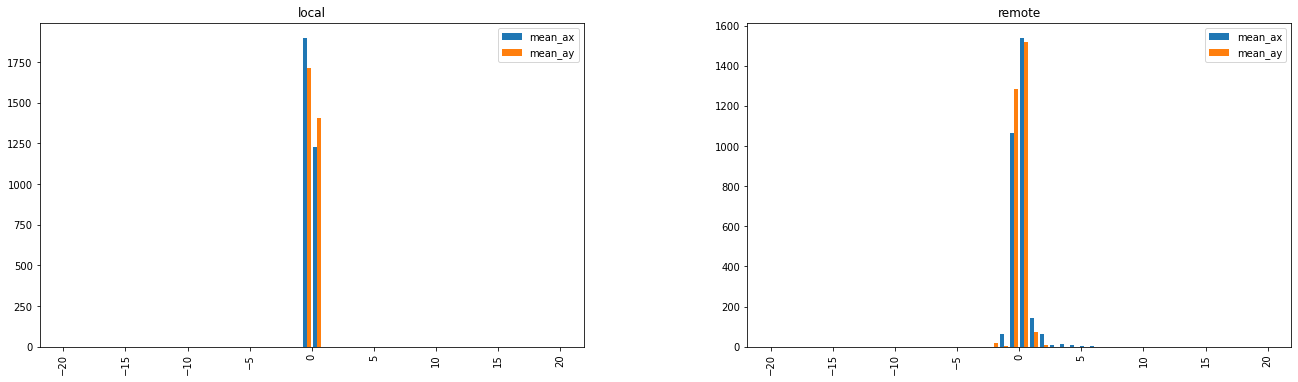

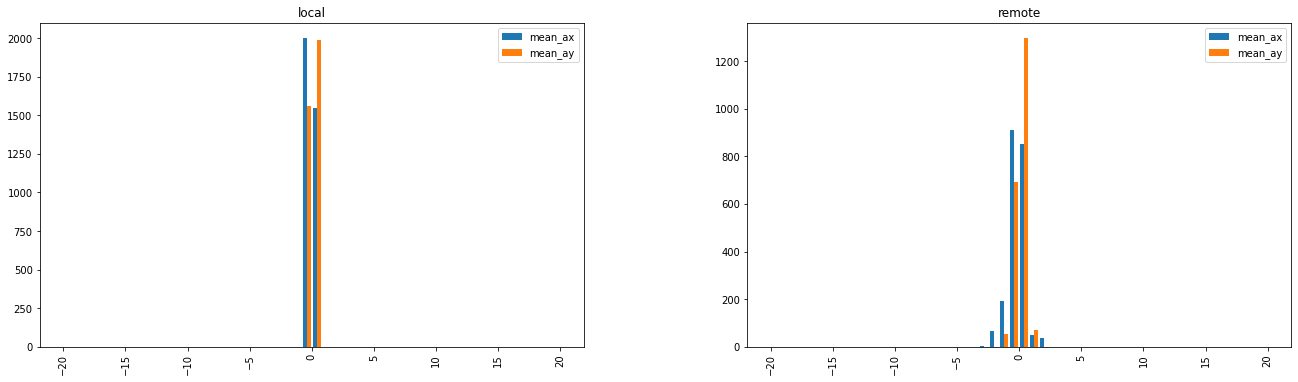

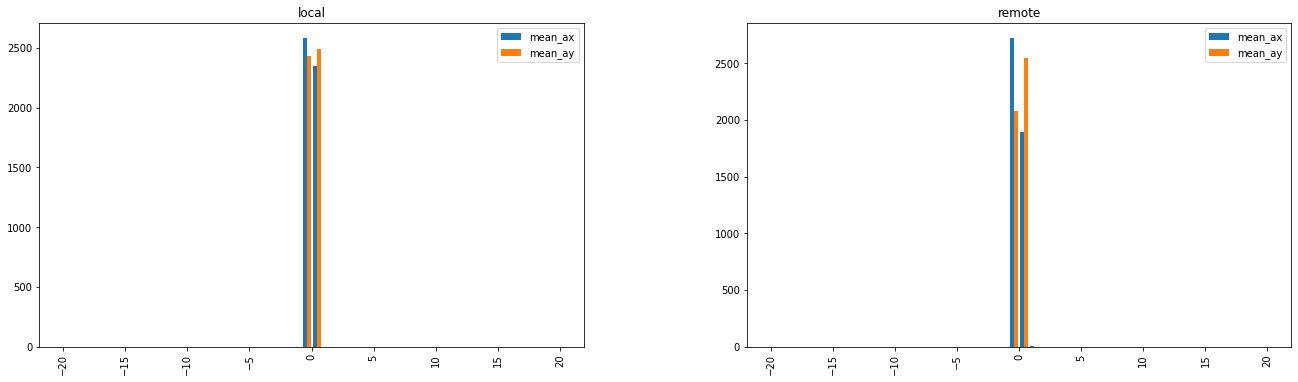

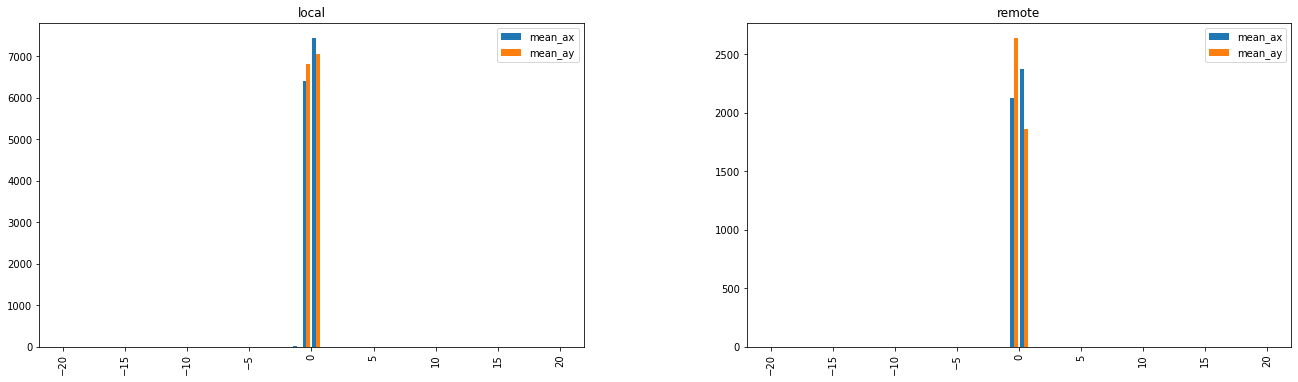

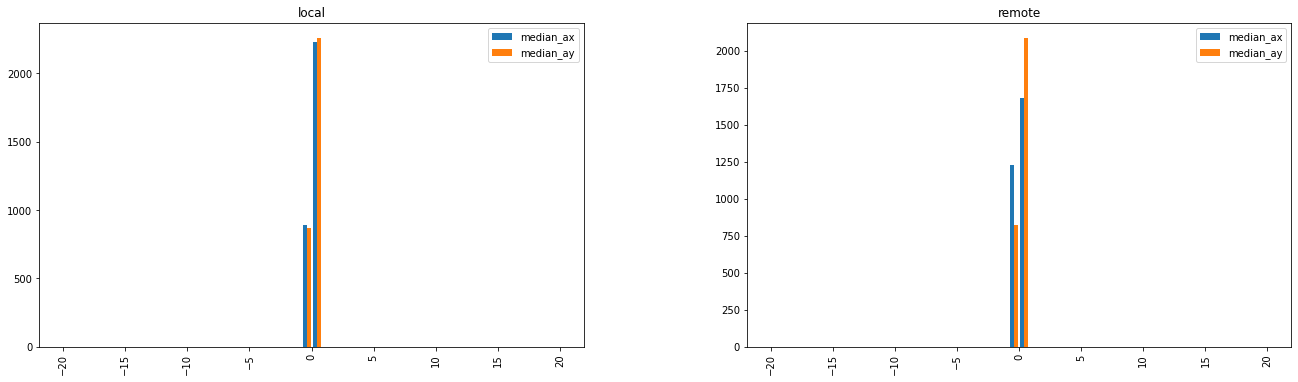

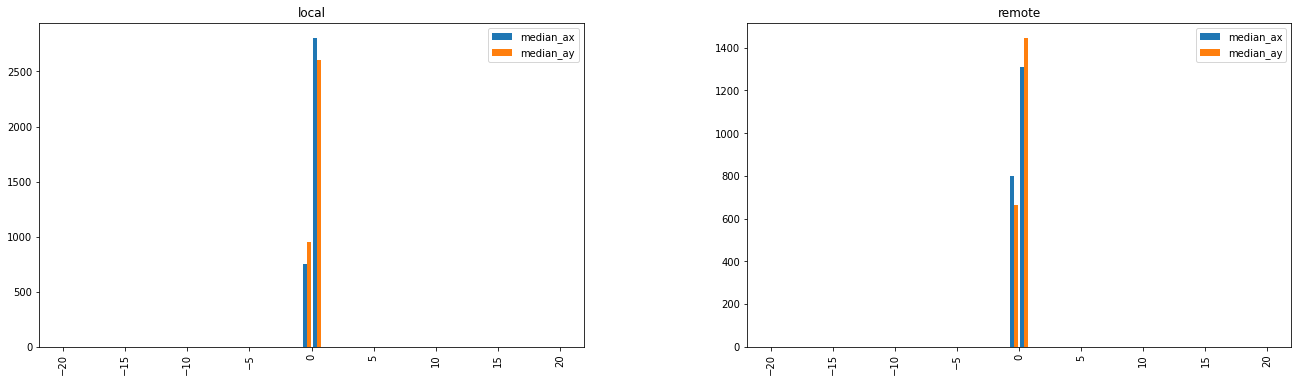

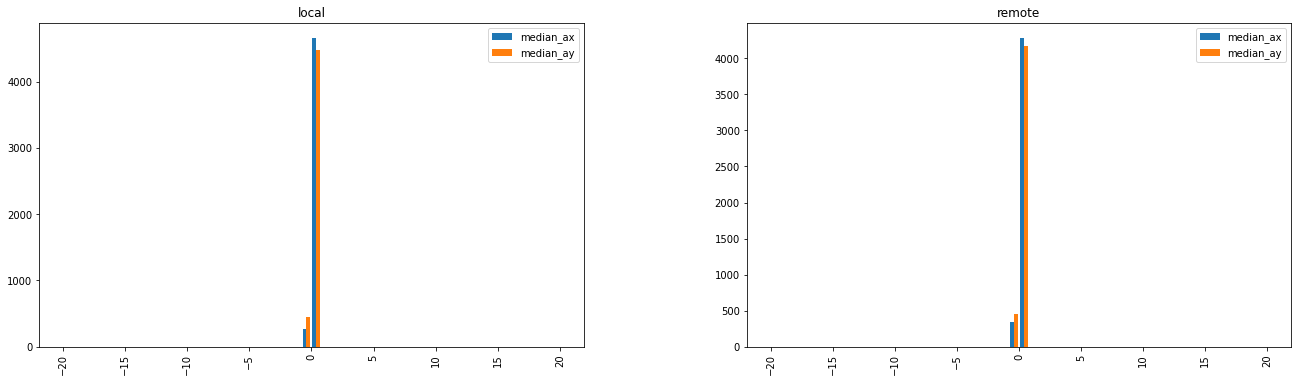

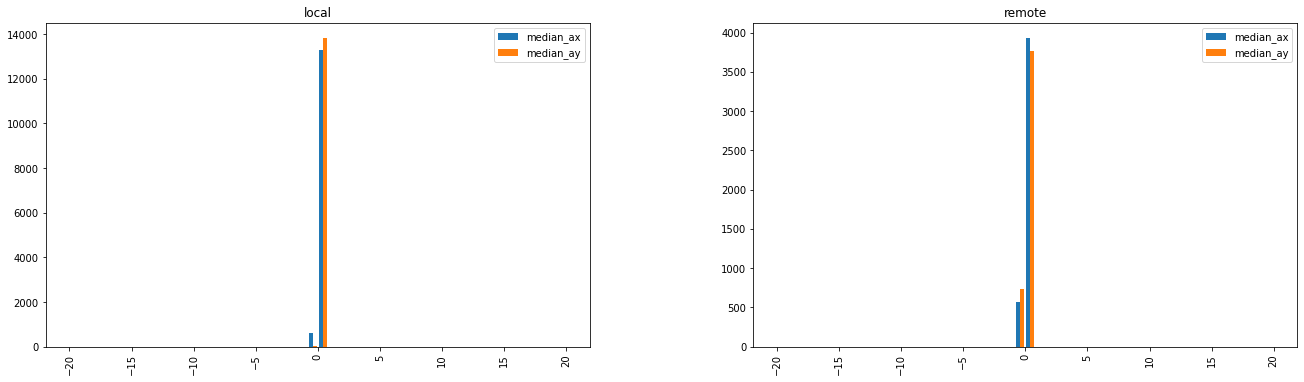

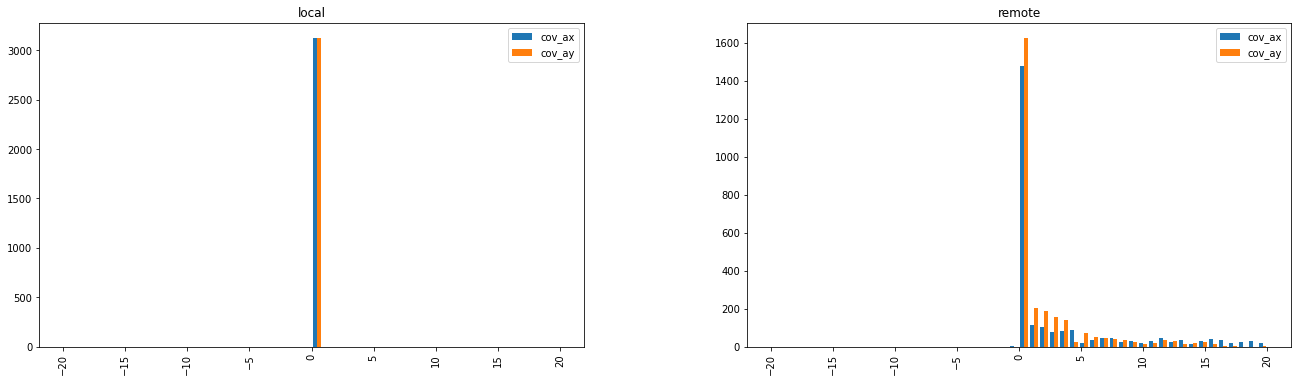

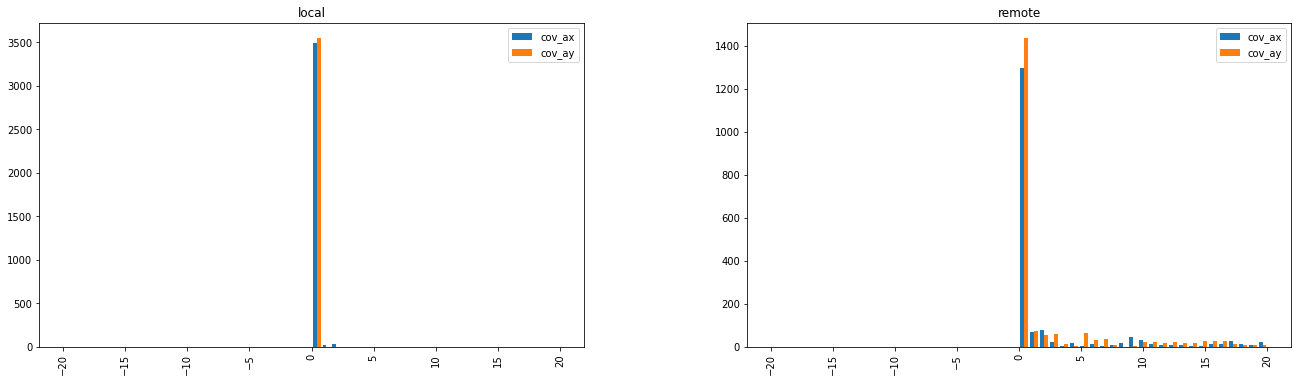

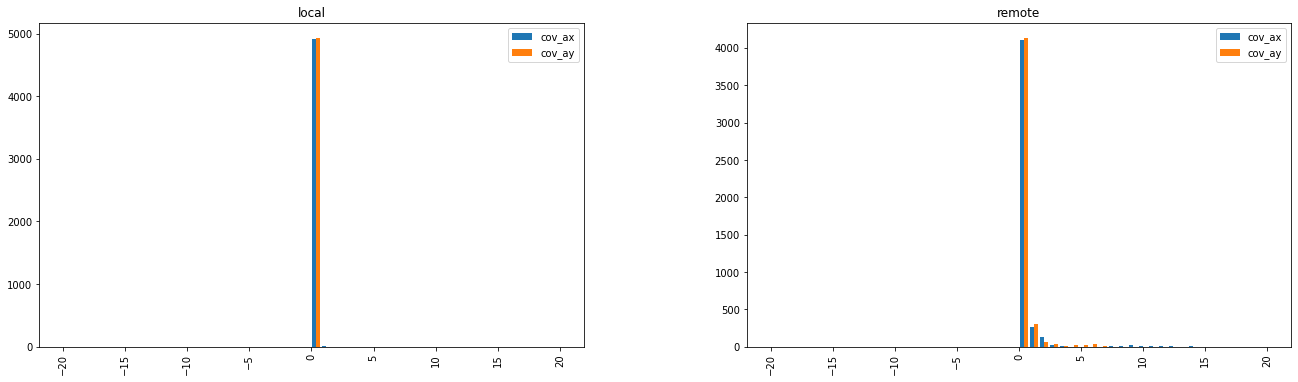

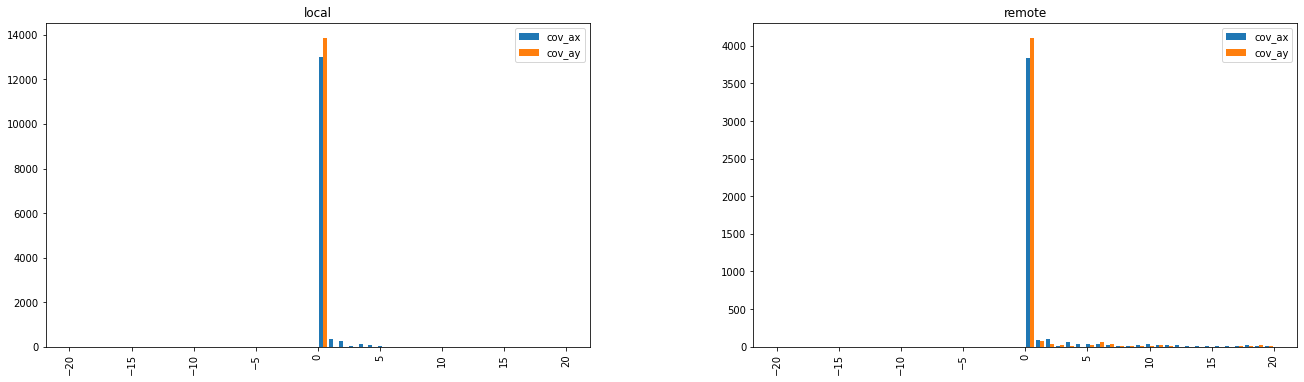

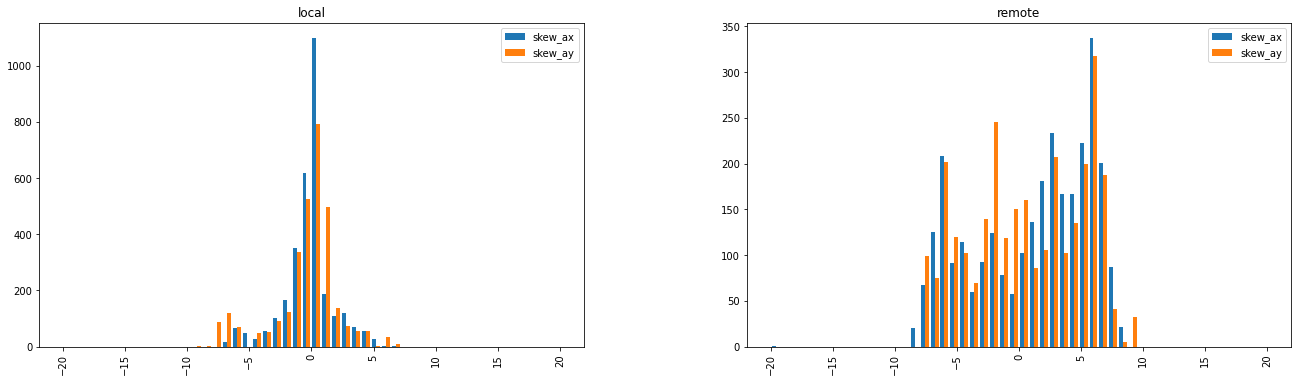

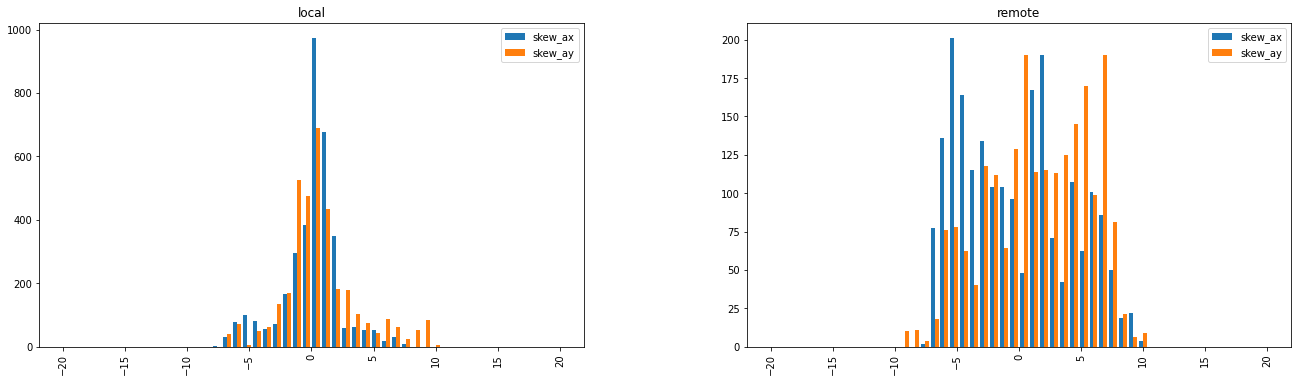

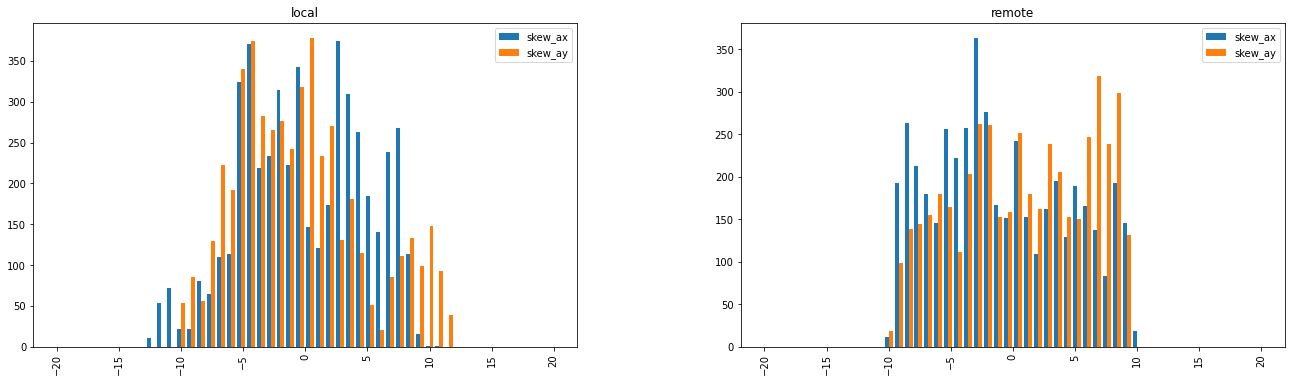

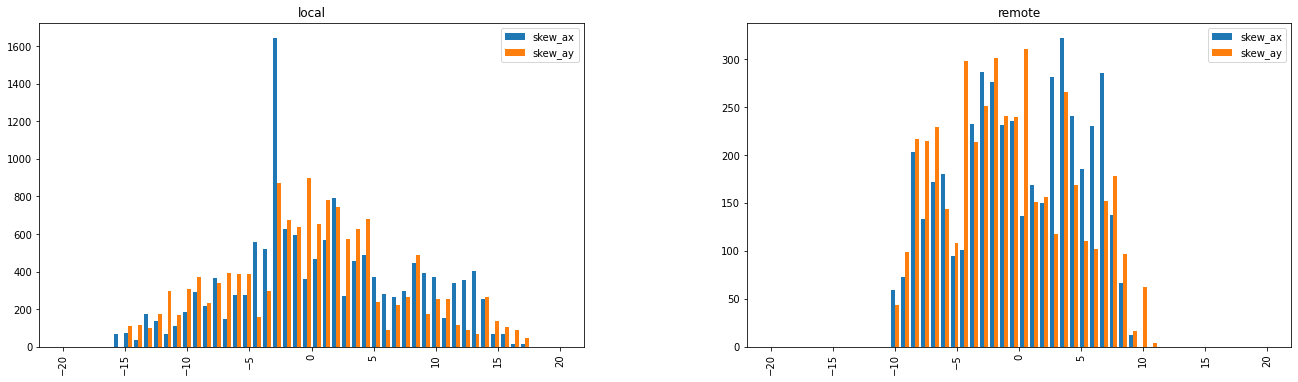

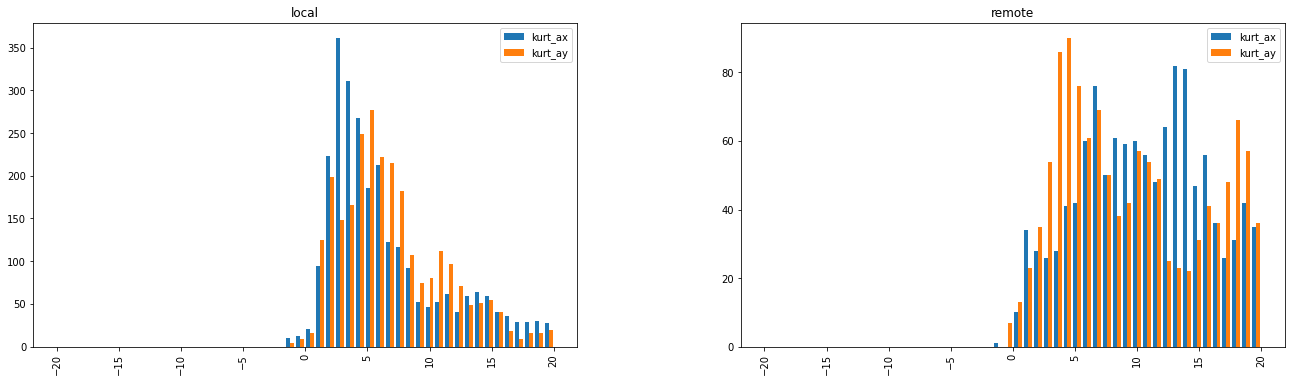

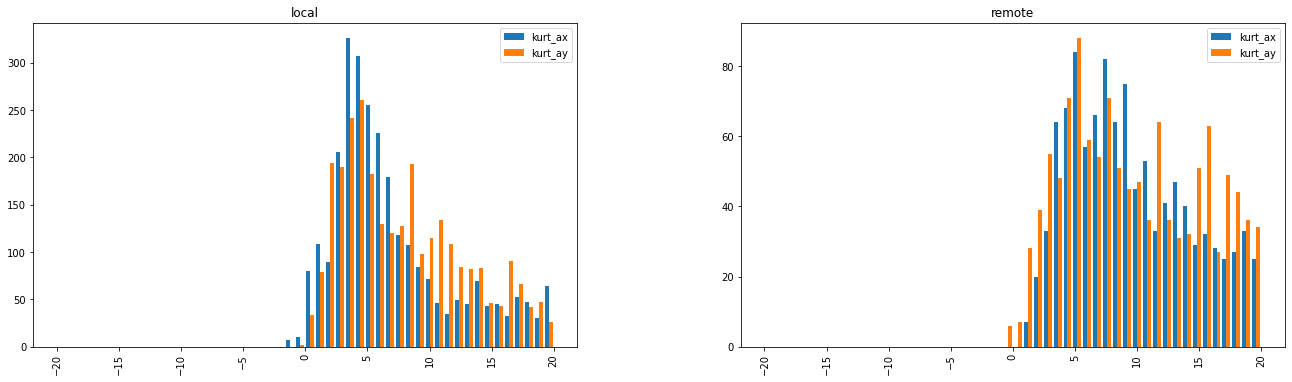

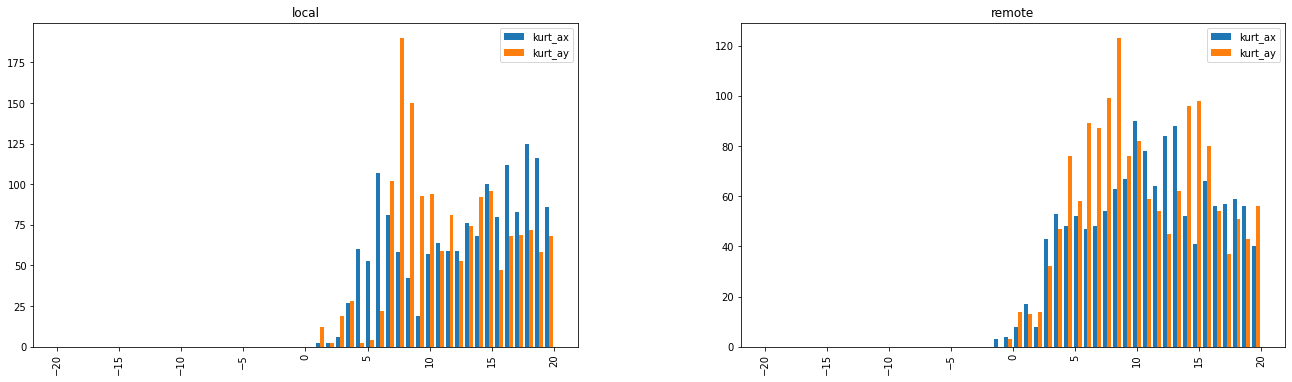

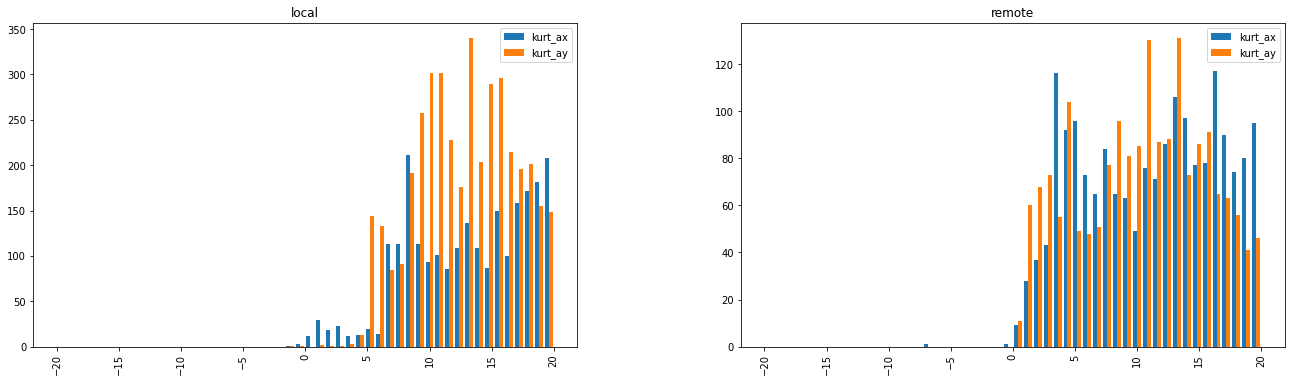

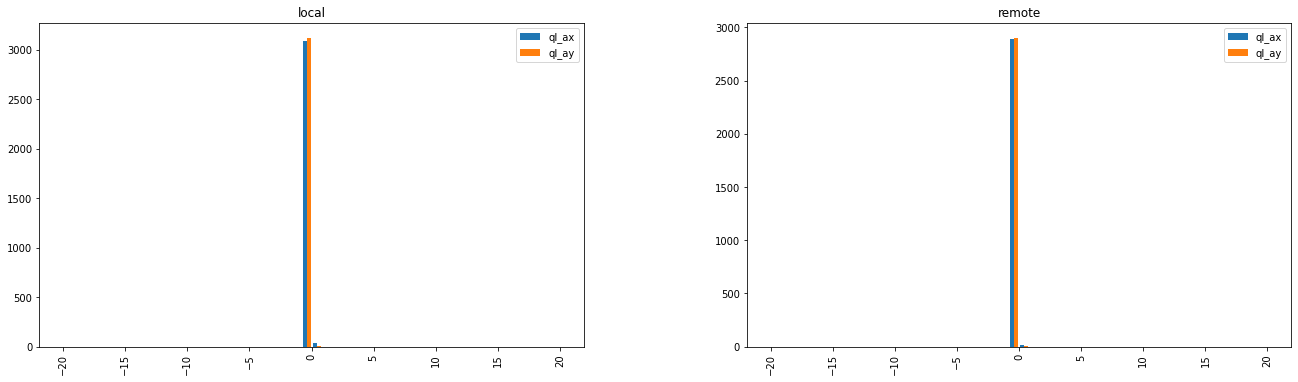

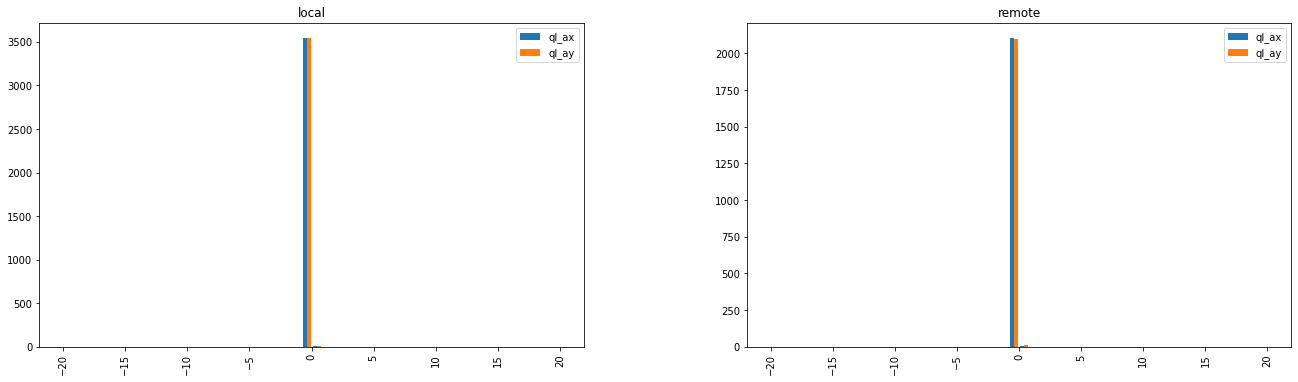

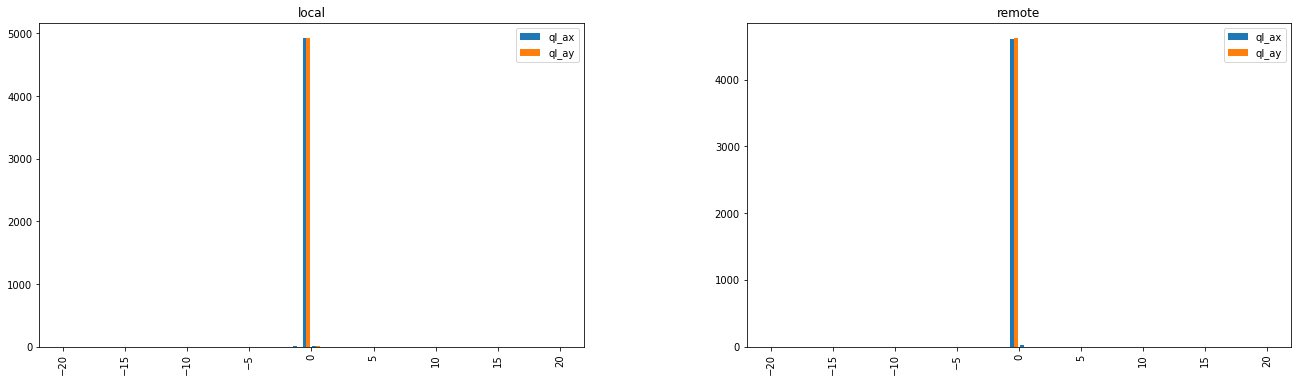

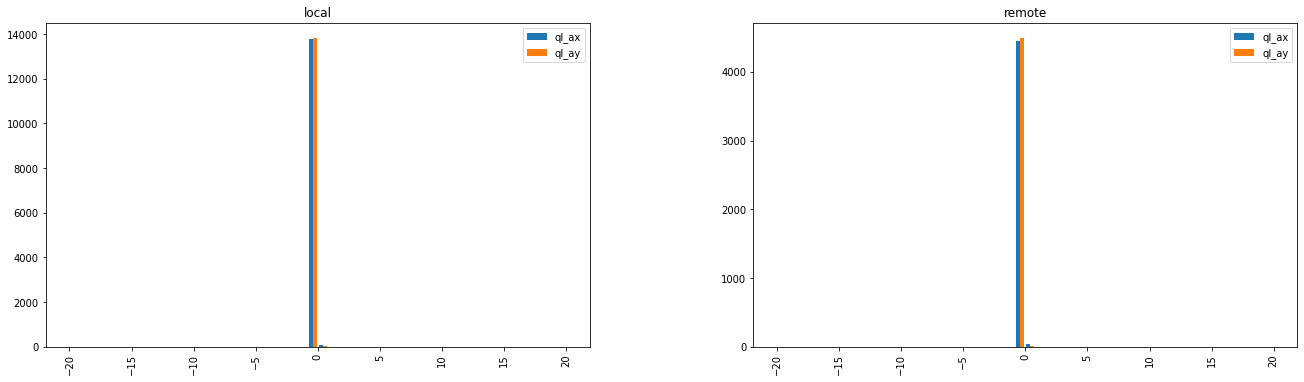

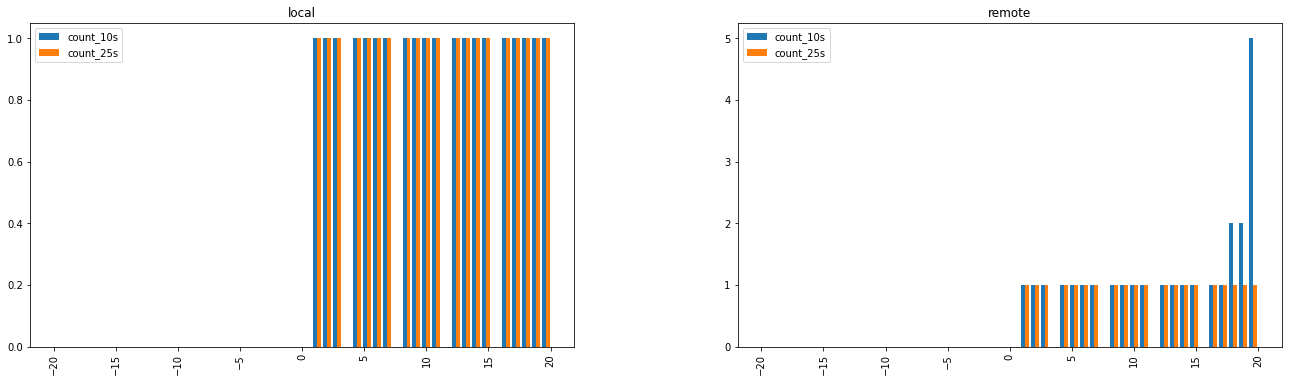

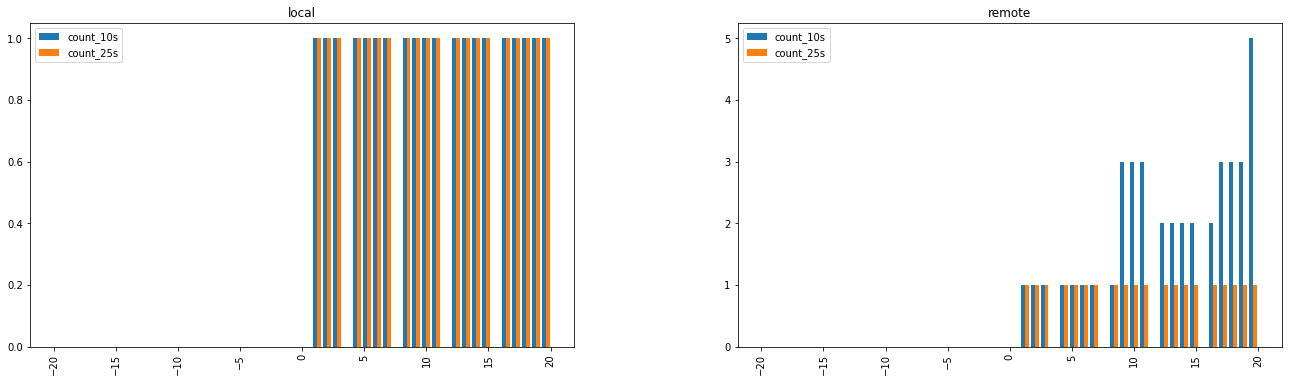

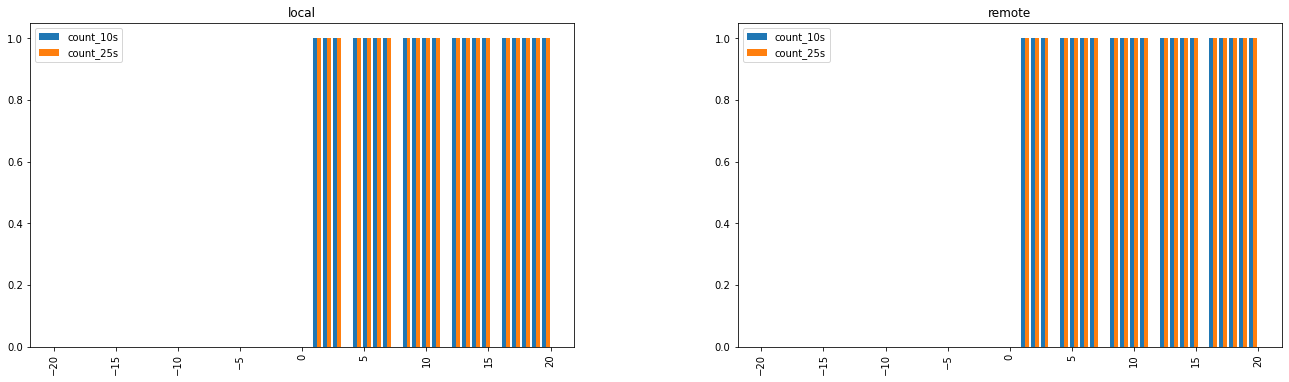

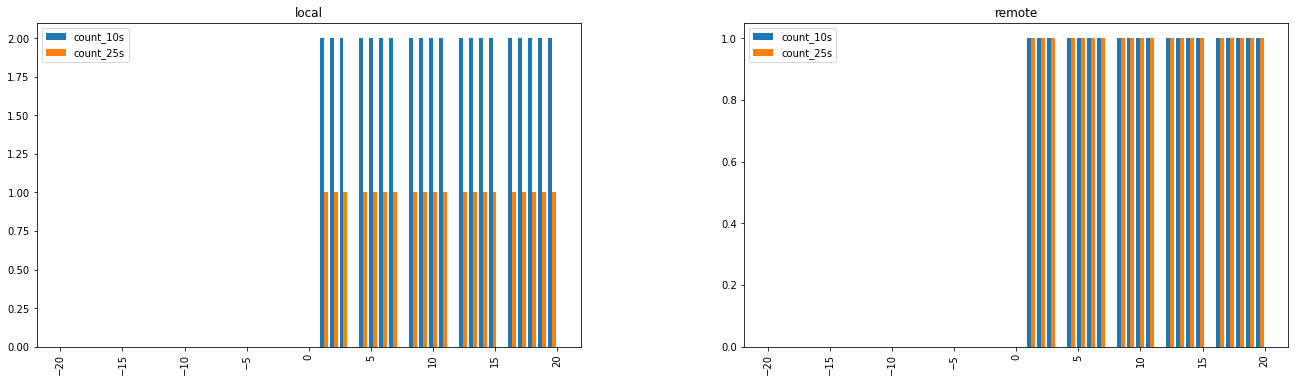

In [12]:
 vd = [ 
        ['dx',        'dy',        'session', 'sid'],
        ['std_dx',    'std_dy',    'session', 'sid'],
        ['mean_dx',   'mean_dy',   'session', 'sid'],
        ['median_dx', 'median_dy', 'session', 'sid'],
        ['cov_dx',    'cov_dy',    'session', 'sid'],
        ['skew_dx',   'skew_dy',   'session', 'sid'] ,
        ['kurt_dx',   'kurt_dy',   'session', 'sid'], 
        ['ql_dx',     'ql_dy',     'session', 'sid'] ,

        ['ax',        'ay',        'session', 'sid'],
        ['std_ax',    'std_ay',    'session', 'sid'],
        ['mean_ax',   'mean_ay',   'session', 'sid'],
        ['median_ax', 'median_ay', 'session', 'sid'],
        ['cov_ax',    'cov_ay',    'session', 'sid'],
        ['skew_ax',   'skew_ay',   'session', 'sid'] ,
        ['kurt_ax',   'kurt_ay',   'session', 'sid'], 
        ['ql_ax',     'ql_ay',     'session', 'sid'] ,


        ['count_10s',     'count_25s',     'session', 'sid'] ,
       
       
      ]
for mask in vd :
  mdp[mask].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
  plt.show()


## Analiza częstości próbkowania

Sprawdzam ile danych pomiarowych przeciętnie mieści się w oknach czasowych np 5s, 10s, 30s, dla sesji remote i local

Poniżej znajdują się wykresy pokazujące ilość próbek pozycji myszy w oknie czasowym. Okno przesuwane jest w sposób ciągły.

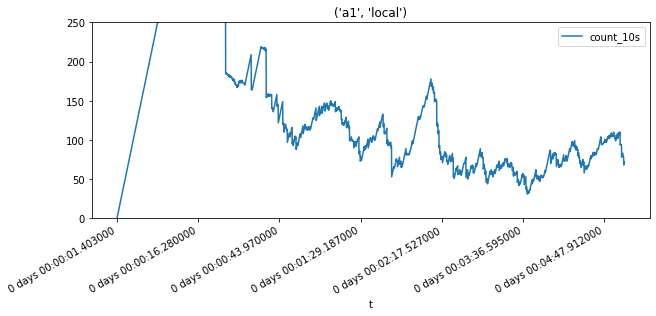

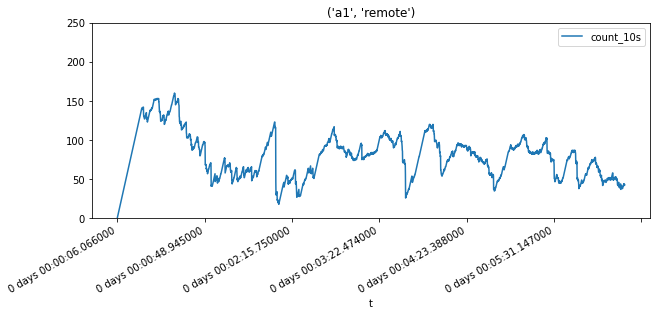

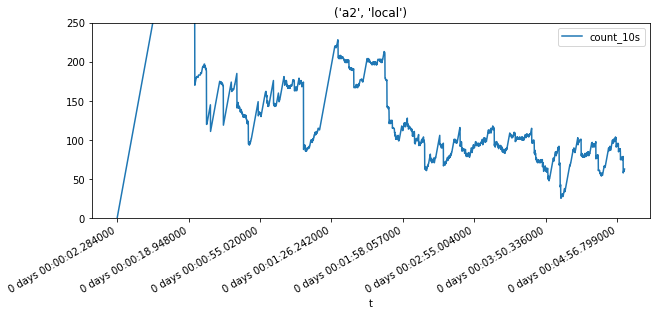

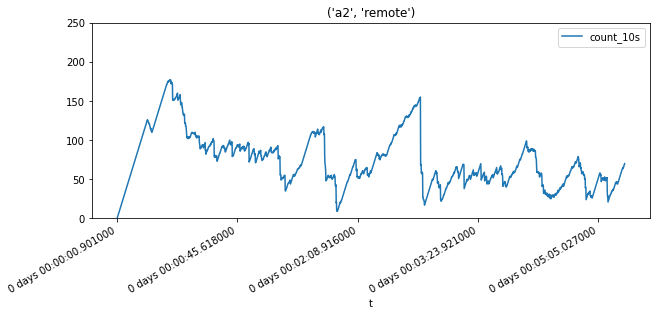

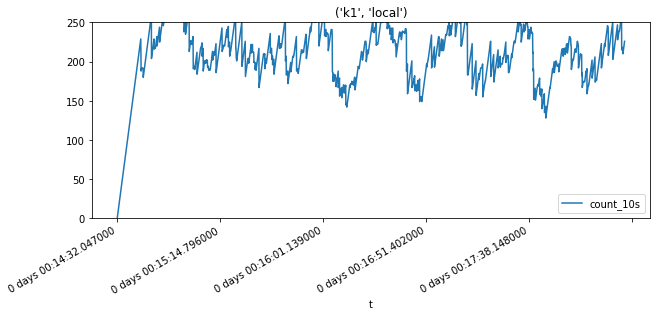

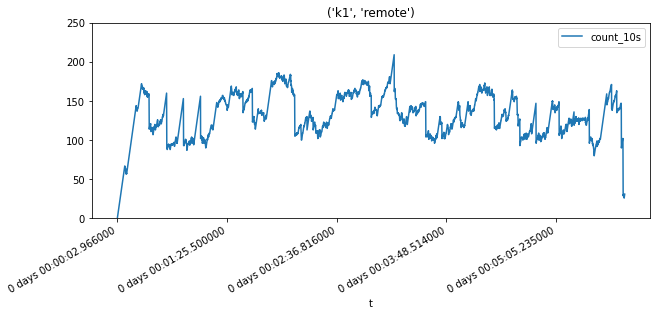

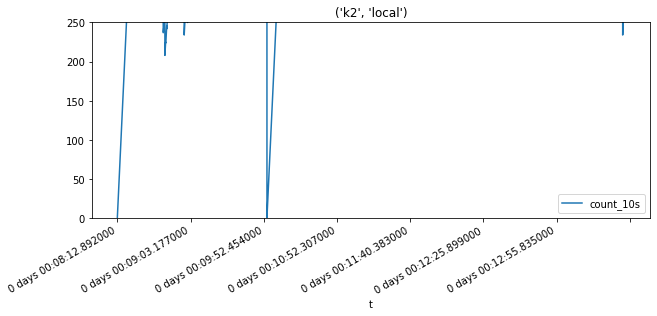

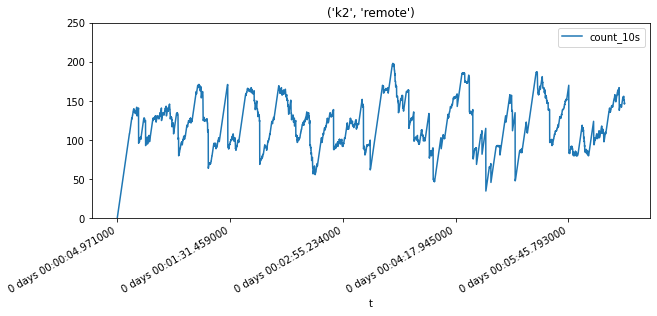

In [13]:
for name, g in mdp.groupby(['sid','session']):
  g.plot(  kind='line', y='count_10s', title=str(name), ylim=(0,250),figsize=(10,4))

Ten wykres przedstawia sesje z linią trendu

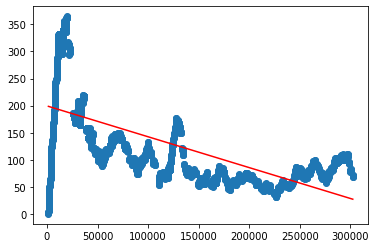

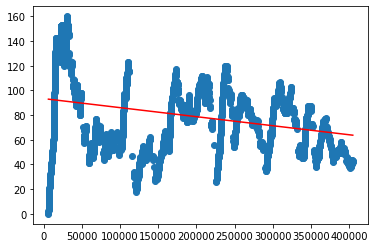

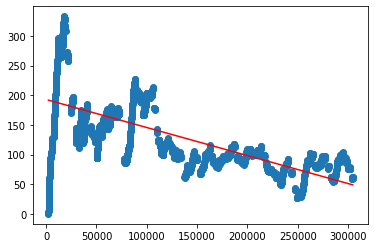

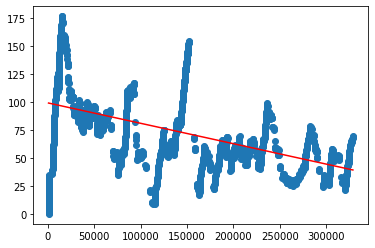

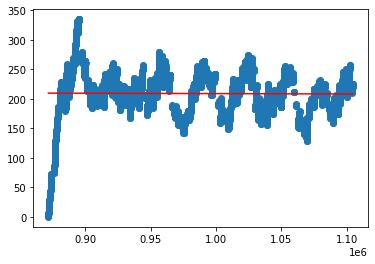

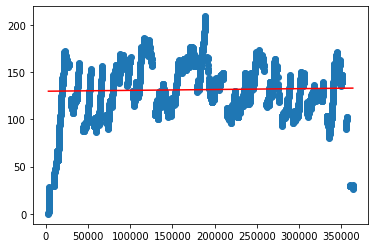

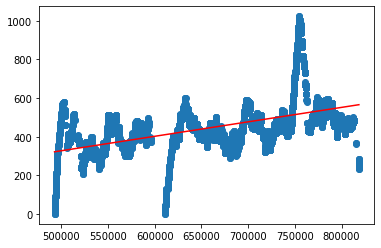

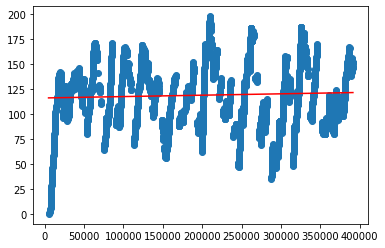

In [14]:
for name, data in mdp.groupby(['sid','session']):
  # Regresion
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_10s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  # Plot
  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')
  plt.show()



Ponizszy zestaw wykresów porównuje linie trendu tej samej sesji dla podłączenia zdalnego i lokalnego.

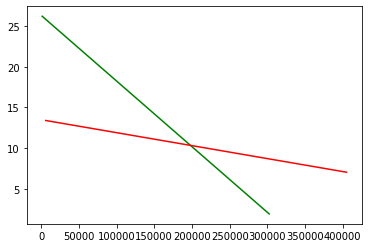

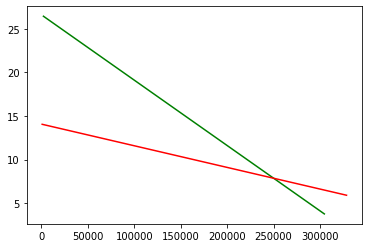

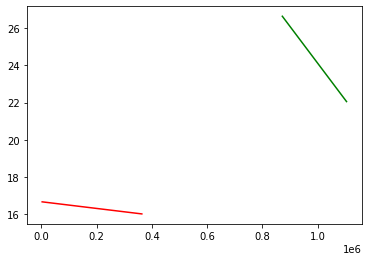

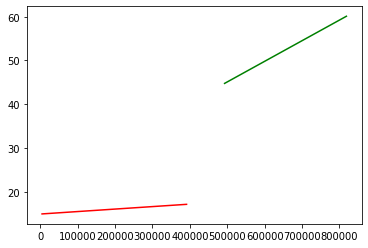

In [15]:
def reg(data):
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_1s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return (X,Y,Y_pred)

for name, sidg in mdp.groupby(['sid']):
  data_l = sidg.groupby('session').get_group('local')
  data_r = sidg.groupby('session').get_group('remote')
  lreg = reg(data_l)
  rreg = reg(data_r)
  # Plot
  plt.plot(lreg[0], lreg[2], color='green')
  plt.plot(rreg[0], rreg[2], color='red')
  plt.show()

porównanie na jednym wykresie lini trendu sesji zdalnych i lokalnych

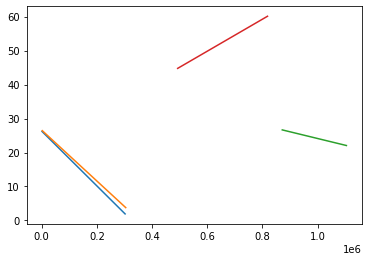

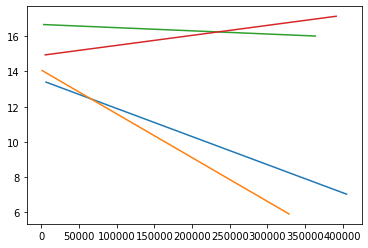

In [16]:
for name, session_df in mdp.groupby(['session']):
  for name, sid_df in session_df.groupby(['sid']):
    r = reg(sid_df)
    plt.plot(r[0], r[2])
  plt.show()

## zbiorcze mini histograamy

ValueError: ignored

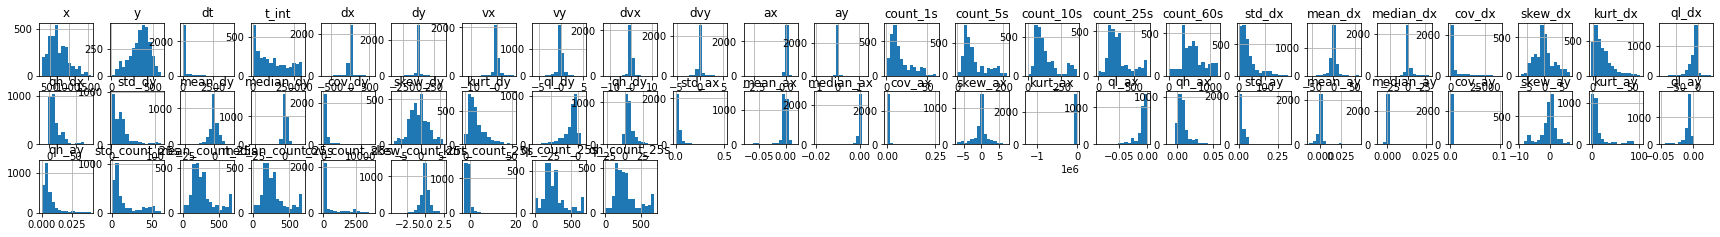

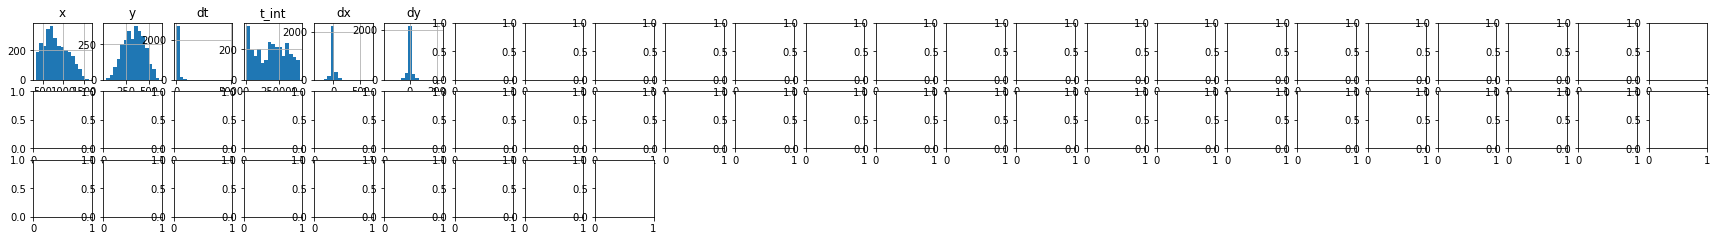

In [17]:
mdp.groupby(['sid','session']).hist(layout=(24,24),figsize=(30,30),bins=15)

## zależność od czasu

In [ ]:
mdp.groupby(['sid','session']).plot(kind="line",y="std_dy")

### przyspieszenie


/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

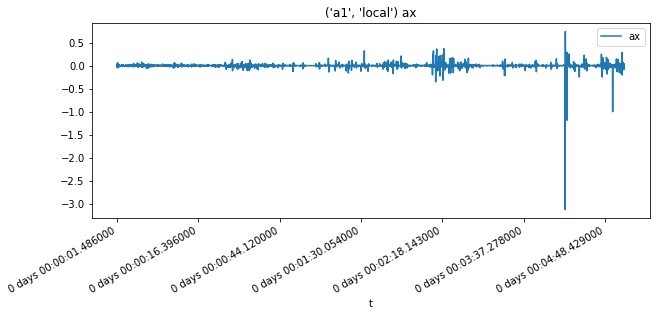

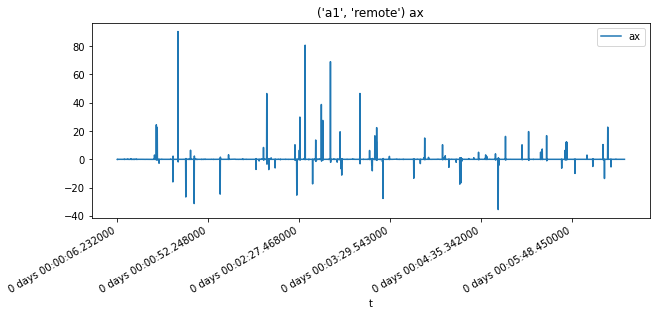

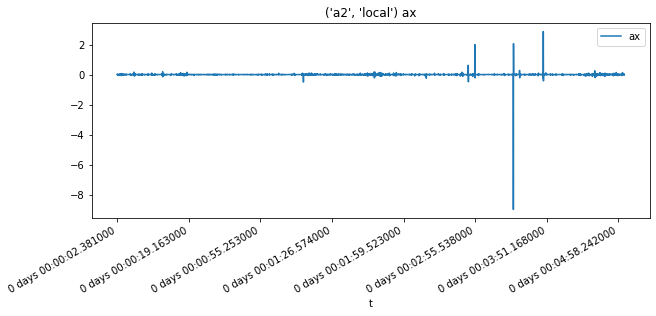

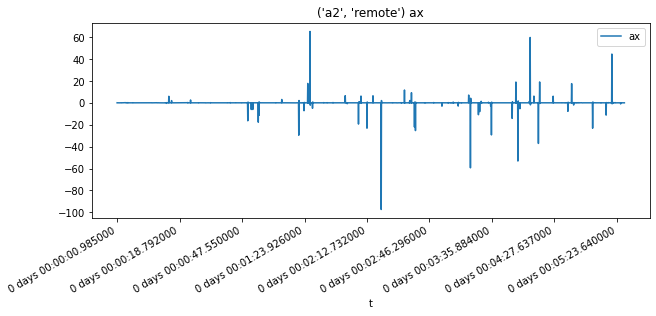

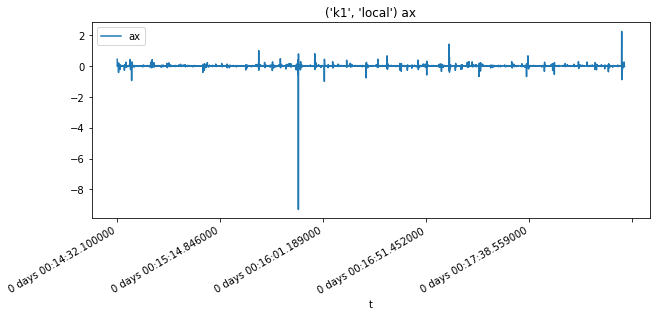

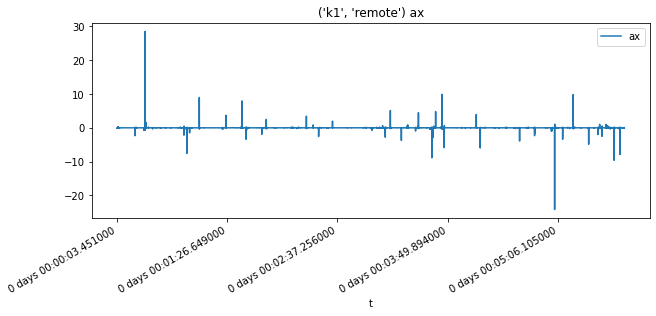

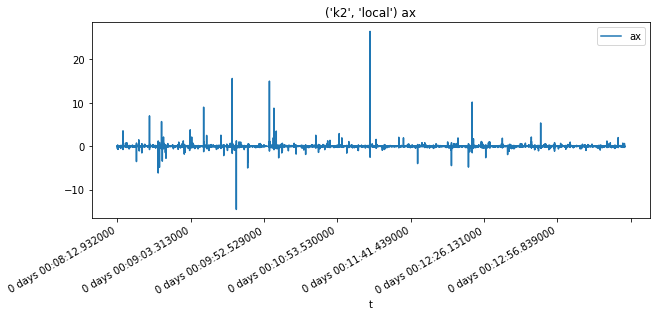

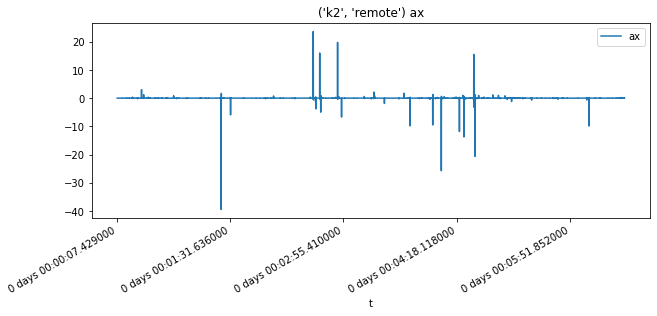

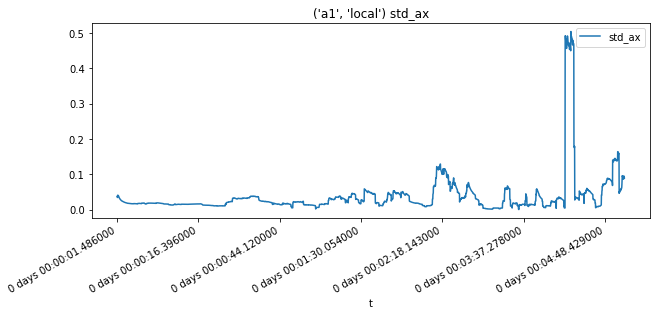

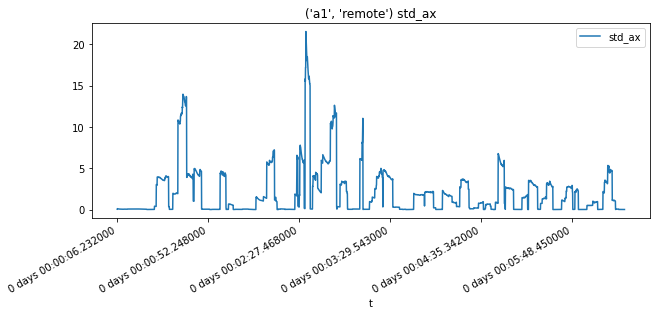

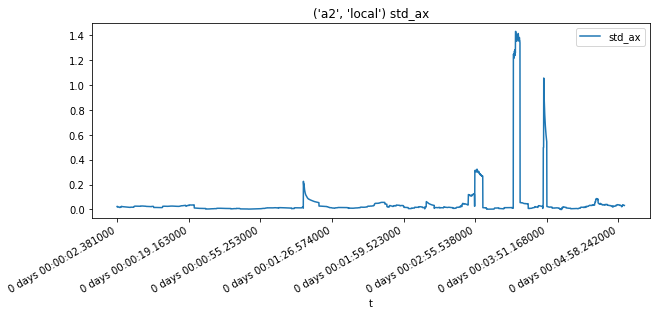

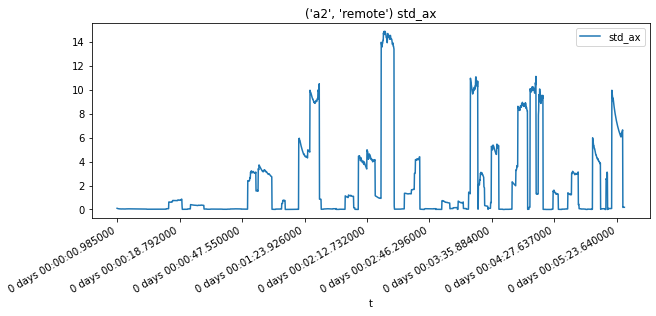

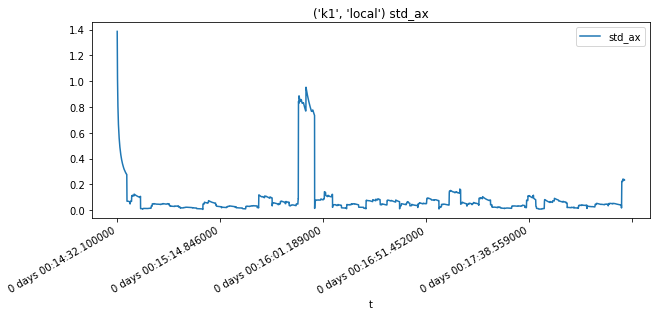

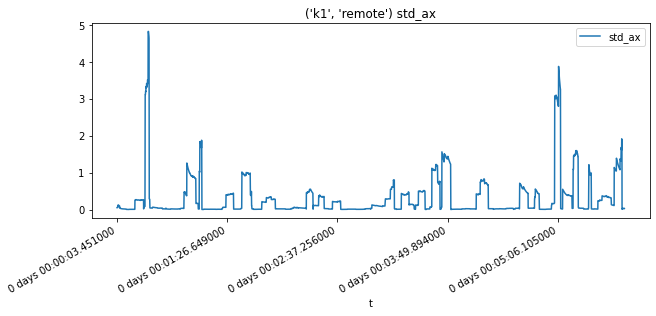

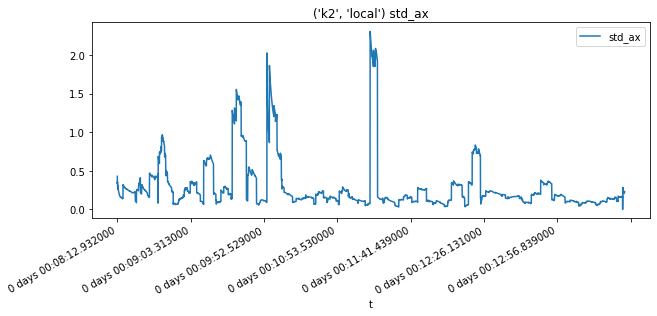

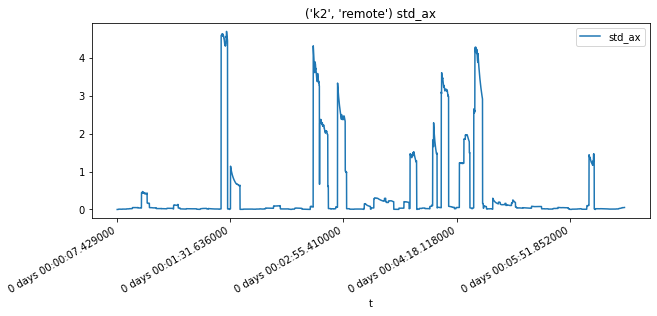

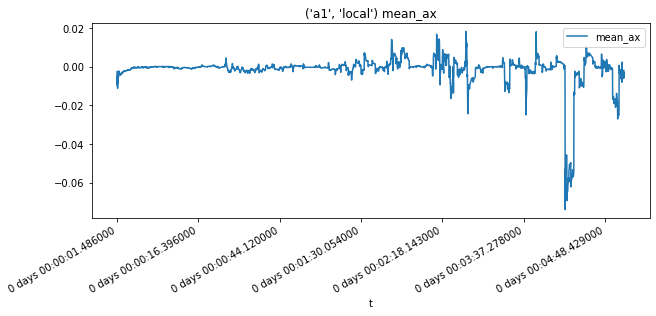

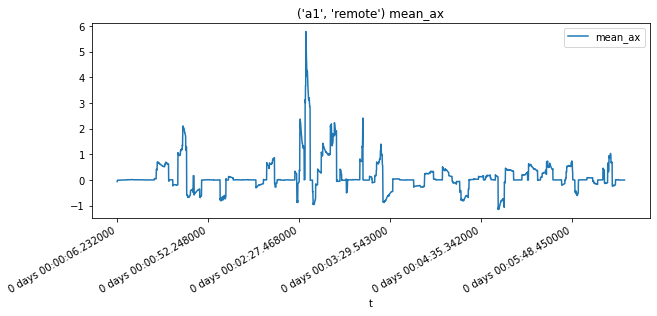

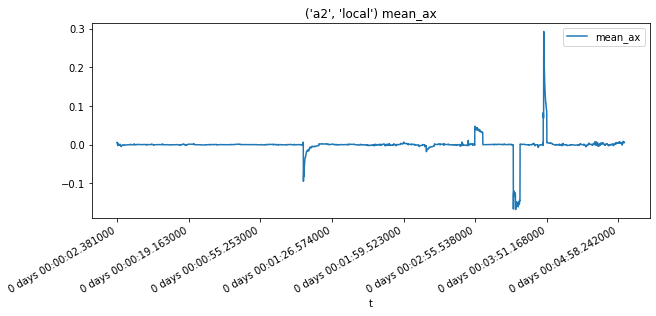

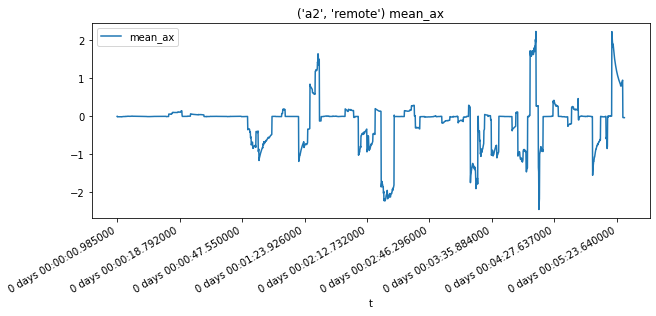

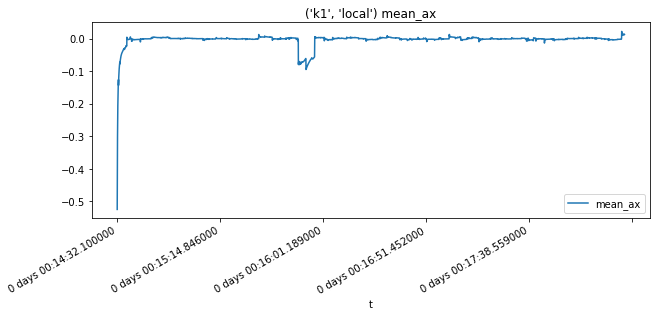

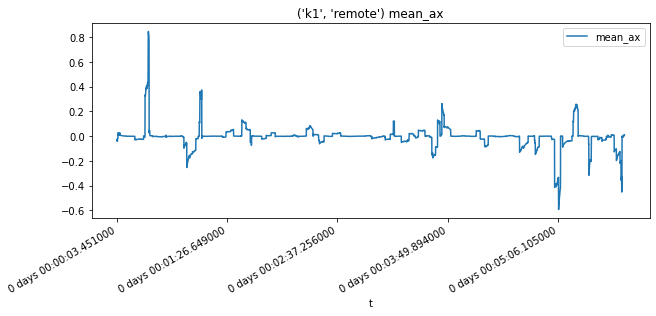

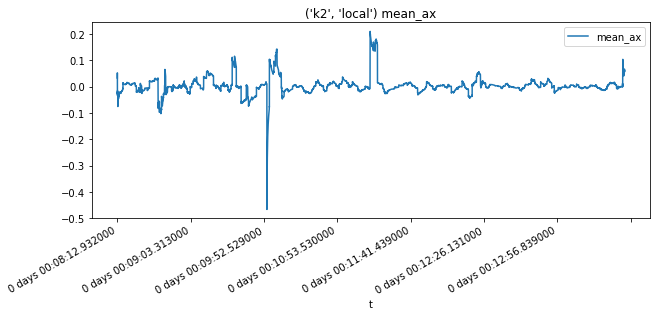

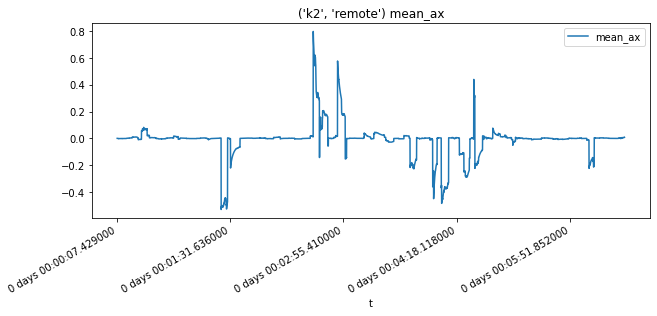

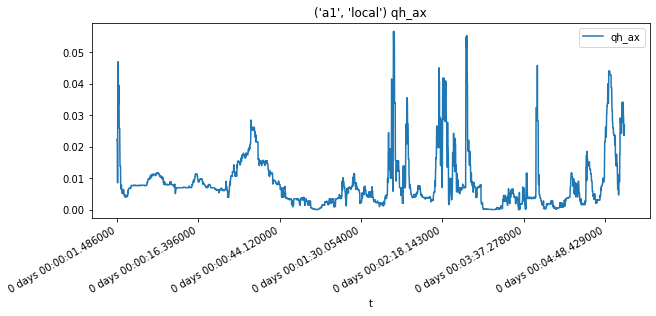

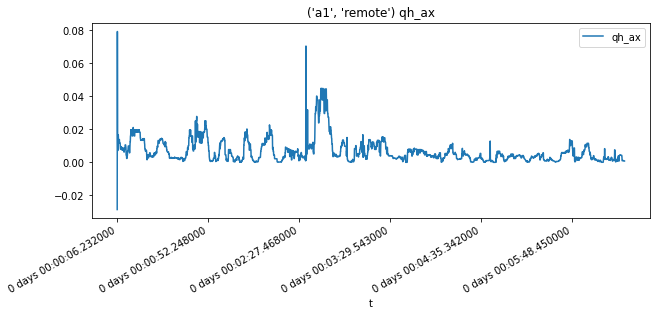

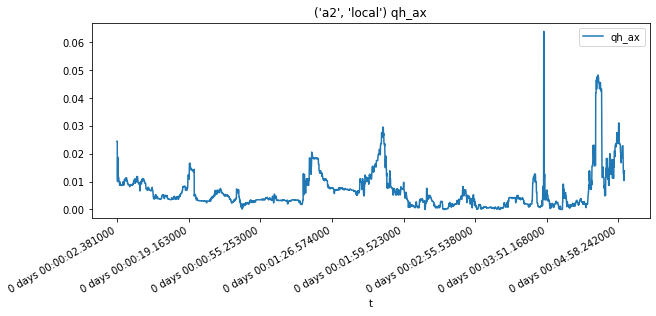

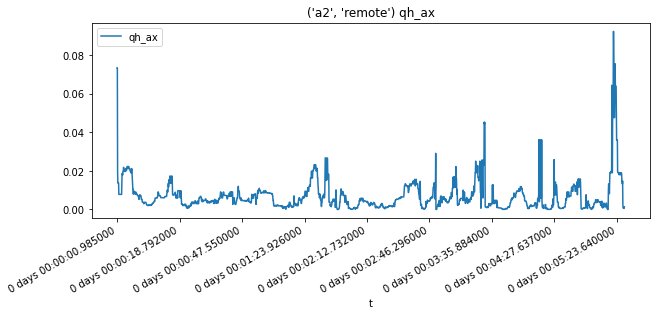

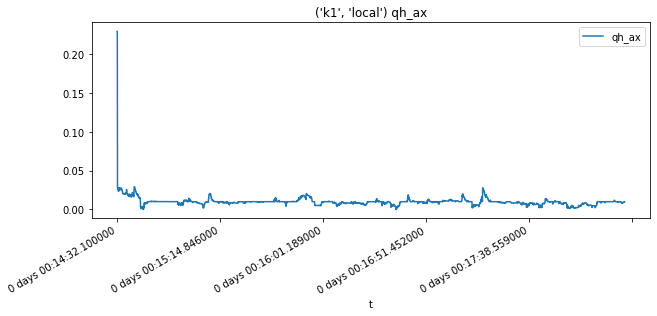

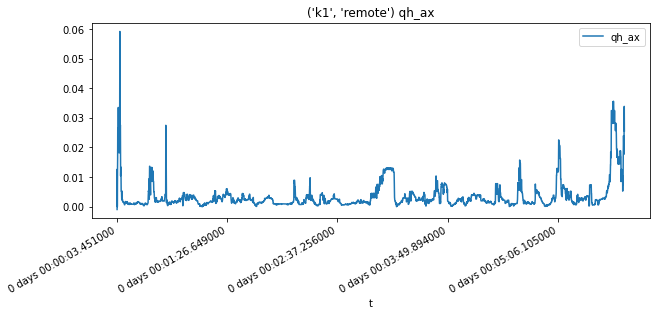

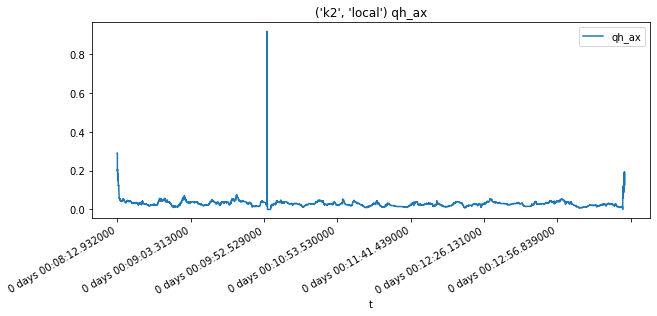

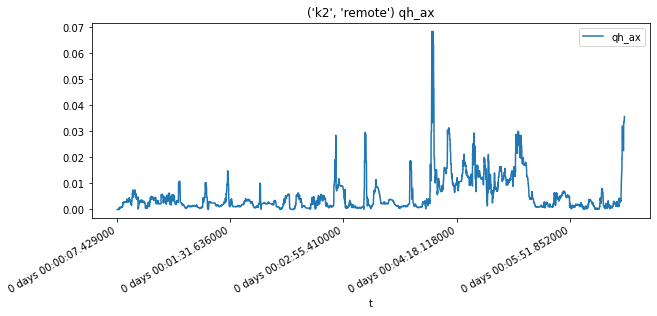

In [82]:
for col in ['ax', 'std_ax', 'mean_ax', 'qh_ax']:
  for name, g in mdp.groupby(['sid','session']):
    g.plot(  kind='line', y=col, title=(str(name)+" "+col),figsize=(10,4))


# Nowa sekcja

# Badanie zmiany krzywizny rozkładu


## Przygotowanie danych

In [ ]:
# MAX_L='2m' # Maxymalna długość sesji
WIN_L='60s'

# Dla kazdego file obciać długość do MAX_L
# def timecut():

def winLabel(data):
  groups = data.group(['session','sid'])
  groupIter = iter(groups)
  for in groupIter.next():




## wizualne porównanie rozkładów dx, dy w małych oknach

Dla próbki local i remote generuję N histogramów dla danych o długości M.
Celem tego kroku jest sprawdzenie czy na poziomie małej rozdzielczości danych np 5s, 15s, 20s widoczne są różnice na wykresach tak jak dla zbiorczego histogramu w sekcji **Wykresy**.


In [ ]:
mdp2 = mdp[['dx','session','sid', 't_int']][(mdp.sid == "a1")]

#w=20
#for idx in range(1,20):
  #mdp2[((mdp2.t_int > (10000+idx*w*1000) ) & (mdp2.t_int < (10000 + idx*w*1000 + idx*w*1000)) )].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
mdp2[((mdp2.t_int > (10000) ) & (mdp2.t_int < (20000 )) )].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
mdp2[((mdp2.t_int > (40000) ) & (mdp2.t_int < (60000 )) )].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
mdp2[((mdp2.t_int > (80000) ) & (mdp2.t_int < (100000 )) )].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
mdp2[((mdp2.t_int > (110000) ) & (mdp2.t_int < (1300000 )) )].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
